# Fig3: Dissecting the structural basis of burst and sustained dynamics through domain swapping

In [1]:
# Fig3: Dissecting the structural basis of burst and sustained dynamics through domain swapping

import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az


In [ ]:

df_A = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/101324-k401-titration-rt/2p5TMB-1ulDNA_/output_data_/merged_expression_PIV.csv")
df_C_E_G = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/111624-C-E-G-RT/2p5ulTMB-0p5MT-1ulDNA_/output_data/merged_expression_PIV.csv")
df_H = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/100624-kif3-titration-RT/2p5ulTMB-1ulDNAXnM_/output_data/merged_expression_PIV.csv")
df_H = df_H[df_H['condition'].str.contains('Kif3_') & df_H['condition'].str.contains('_1-RT')]

df_D = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/110324-D_titration-RT/2p5TMB-1ulDNA_1/output_data/merged_expression_PIV.csv")

df_B_F = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/111024-B-F-titrations-RT/2p5TMB-1ulDNA_/output_data/combined_expression.csv")

# Change the column names in df_B_F to be lowercase for 'Condition' and 'Subcondition'
df_B_F.rename(columns={'Condition': 'condition', 'Subcondition': 'subcondition'}, inplace=True)

df_ThTr = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/020124-ThTr-titrations-RT/2p5ulTMB-1ulDNA_/output_data/merged_expression_PIV.csv")

df_AcSu2 = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/021025-BleSto-AcSu2-titrations/2p5ulTMB-1ulDNA_1/output_data/merged_expression_PIV.csv")

df_DiPu = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/021025-DiPu-titrations/2p5ulTMB-1ulDNA_1/output_data/merged_expression_PIV.csv")

df_HeAl = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/021625-HeAl-titrations-RT/2p5ulTMB-1ulDNA_/output_data/merged_expression_PIV.csv")

df_NaGr = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/030225-NaGr-titrations/2p5ulTMB_1ulDNA_2/output_data/merged_expression_PIV.csv")

df_AdPa = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/030225-AdPa-titrations/2p5ulTMB_1ulDNA_/output_data/merged_expression_PIV.csv")

df_ThTr_ = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/ubuntu/072025-ThTr-piv-beads/2p5ulTMB-1ulDNA_/output_data/merged_expression_PIV.csv")


###
# Merge the two DataFrames into one
df = pd.concat([df_A, df_H, df_C_E_G, df_D, df_B_F, df_ThTr, df_AcSu2, df_DiPu, df_HeAl, df_NaGr, df_AdPa, df_ThTr_], ignore_index=True, join='outer')
df


,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Unnamed: 0,frame,...,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h),Number of Protein Molecules,Rate of Change of Protein Molecules per Second,Translation Rate aa_s
0,K401_1p25nM-RT,Rep1,0.0,0.000000,0.000000,179.914233,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,K401_1p25nM-RT,Rep1,600.0,10.000000,0.166667,181.127909,0.051565,1.909813,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,K401_1p25nM-RT,Rep1,1200.0,20.000000,0.333333,181.868650,0.083037,3.075428,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,K401_1p25nM-RT,Rep1,1800.0,30.000000,0.500000,182.932426,0.128233,4.749361,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K401_1p25nM-RT,Rep1,2400.0,40.000000,0.666667,184.062858,0.176261,6.528183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251523,H_100nM,Rep1,80440.0,1340.666667,22.344444,128.196440,4.676942,72.623324,2011.0,2011.0,...,148.425604,0.000390,0.000871,8.194767e-21,4.771918e-17,1340.666667,22.344444,8.714799e+10,-2.041311e+05,0.915026
251524,H_100nM,Rep1,80480.0,1341.333333,22.355556,128.348247,4.682480,72.709322,2012.0,2012.0,...,130.864368,0.000392,0.000871,2.088668e-22,4.771939e-17,1341.333333,22.355556,8.725119e+10,-4.733528e+05,0.915655
251525,H_100nM,Rep1,80520.0,1342.000000,22.366667,127.866671,4.664911,72.436509,2013.0,2013.0,...,-48.966848,0.000394,0.000871,3.504694e-22,4.771974e-17,1342.000000,22.366667,8.692381e+10,-2.555440e+05,0.911766
251526,H_100nM,Rep1,80560.0,1342.666667,22.377778,127.832247,4.663655,72.417008,2014.0,2014.0,...,148.458626,0.000396,0.000872,9.252617e-21,4.772899e-17,1342.666667,22.377778,8.690041e+10,5.730808e+05,0.911068


In [101]:
# Split condition column and extract components
df['protein'] = df['condition'].str.split('_').str[0]

# Replace protein names
df['protein'] = df['protein'].replace({'K401': 'A', 'Kif3': 'H'})

# Extract DNA concentration, removing -RT and handling different formats
df['DNA nM'] = df['condition'].str.split('_').str[1].str.replace('-RT', '').str.replace('p', '.').str.replace('nM', '')

df['kDa'] = df['protein'].apply(lambda x: 78 if x in ['A', 'B', 'C', 'D'] else 93 if x in ['E', 'F', 'G', 'H'] else None)


# Remove -RT from condition column
df['condition'] = df['condition'].str.replace('-RT', '')

# multiply all the values of divergence and vorticity by 1000
df['divergence [1/s]_mean'] = df['divergence [1/s]_mean'] * 1000
df['vorticity [1/s]_mean'] = df['vorticity [1/s]_mean'] * 1000

# let's create another column called "protein number". nM to M. Divide by 2µl. Avogadro's number.
df['protein number'] = df['Protein Concentration_nM'] * 1E-9 * 2E-6 * 6.022E23 

# Now let's create a column called "energy per protein" dividing power by protein number
df['energy per protein'] = df['power [W]_mean'] / df['protein number']



# save the dataframe
df.to_csv('../../../Thomson Lab Dropbox/David Larios/activedrops/main/all/motor_dataset.csv', index=False)
df


,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Unnamed: 0,frame,...,time (min),time (h),Number of Protein Molecules,Rate of Change of Protein Molecules per Second,Translation Rate aa_s,protein,DNA nM,kDa,protein number,energy per protein
0,K401_1p25nM,Rep1,0.0,0.000000,0.000000,179.914233,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,0.000000e+00,NaN
1,K401_1p25nM,Rep1,600.0,10.000000,0.166667,181.127909,0.051565,1.909813,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,2.300179e+09,NaN
2,K401_1p25nM,Rep1,1200.0,20.000000,0.333333,181.868650,0.083037,3.075428,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,3.704045e+09,NaN
3,K401_1p25nM,Rep1,1800.0,30.000000,0.500000,182.932426,0.128233,4.749361,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,5.720130e+09,NaN
4,K401_1p25nM,Rep1,2400.0,40.000000,0.666667,184.062858,0.176261,6.528183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,7.862544e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251523,H_100nM,Rep1,80440.0,1340.666667,22.344444,128.196440,4.676942,72.623324,2011.0,2011.0,...,1340.666667,22.344444,8.714799e+10,-2.041311e+05,0.915026,H,100,93.0,8.746753e+10,9.368925e-32
251524,H_100nM,Rep1,80480.0,1341.333333,22.355556,128.348247,4.682480,72.709322,2012.0,2012.0,...,1341.333333,22.355556,8.725119e+10,-4.733528e+05,0.915655,H,100,93.0,8.757111e+10,2.385111e-33
251525,H_100nM,Rep1,80520.0,1342.000000,22.366667,127.866671,4.664911,72.436509,2013.0,2013.0,...,1342.000000,22.366667,8.692381e+10,-2.555440e+05,0.911766,H,100,93.0,8.724253e+10,4.017186e-33
251526,H_100nM,Rep1,80560.0,1342.666667,22.377778,127.832247,4.663655,72.417008,2014.0,2014.0,...,1342.666667,22.377778,8.690041e+10,5.730808e+05,0.911068,H,100,93.0,8.721904e+10,1.060848e-31


In [102]:
df_old = pd.read_csv('../../../Thomson Lab Dropbox/David Larios/activedrops/main/091024-sustainedMotors-RT/2p5TMB-1ulDNA100nM_/output_data/merged_expression_PIV.csv')

# Filter the dataframe for the condition 'Kif5-RT'
df_kif5_rt = df_old[df_old['condition'] == 'Kif5-RT']

# Add specific values for 'protein', 'DNA nM', 'kDa' for Kif5-RT
df_kif5_rt['protein'] = 'Kif5'
df_kif5_rt['DNA nM'] = '160'
df_kif5_rt['kDa'] = '100'

# Concatenate df_kif5_rt to df
df = pd.concat([df, df_kif5_rt], ignore_index=True, join='outer')

# Display the concatenated dataframe
df


/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_2490/404300931.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kif5_rt['protein'] = 'Kif5'
/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_2490/404300931.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kif5_rt['DNA nM'] = '160'
/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_2490/404300931.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Unnamed: 0,frame,...,time (min),time (h),Number of Protein Molecules,Rate of Change of Protein Molecules per Second,Translation Rate aa_s,protein,DNA nM,kDa,protein number,energy per protein
0,K401_1p25nM,Rep1,0.0,0.00,0.000000,179.914233,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,0.000000e+00,NaN
1,K401_1p25nM,Rep1,600.0,10.00,0.166667,181.127909,0.051565,1.909813,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,2.300179e+09,NaN
2,K401_1p25nM,Rep1,1200.0,20.00,0.333333,181.868650,0.083037,3.075428,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,3.704045e+09,NaN
3,K401_1p25nM,Rep1,1800.0,30.00,0.500000,182.932426,0.128233,4.749361,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,5.720130e+09,NaN
4,K401_1p25nM,Rep1,2400.0,40.00,0.666667,184.062858,0.176261,6.528183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,7.862544e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254444,Kif5-RT,Rep1,131220.0,2187.00,36.450000,190.583435,6.952983,122.844224,972.0,972.0,...,2187.0,36.45,1.474131e+11,1.696103e+05,1.123404,Kif5,160,100,NaN,NaN
254445,Kif5-RT,Rep1,131265.0,2187.75,36.462500,190.480494,6.949227,122.777871,NaN,NaN,...,NaN,NaN,1.473334e+11,-5.184094e+04,1.122412,Kif5,160,100,NaN,NaN
254446,Kif5-RT,Rep1,131310.0,2188.50,36.475000,190.451463,6.948168,122.759158,NaN,NaN,...,NaN,NaN,1.473110e+11,-3.710032e+05,1.121857,Kif5,160,100,NaN,NaN
254447,Kif5-RT,Rep1,131355.0,2189.25,36.487500,190.539299,6.951373,122.815775,NaN,NaN,...,NaN,NaN,1.473789e+11,-7.185790e+05,1.121989,Kif5,160,100,NaN,NaN


In [109]:
### chimeras 29C
df_old = pd.read_csv('../../../Thomson Lab Dropbox/David Larios/activedrops/main/090124-chimeras100nM-29C/2p5ul_TMBmix-1ulDNA100nM_/output_data/merged_expression_PIV.csv')
# Replace '-29C' with '_100nM' in the condition column
df_old['condition'] = df_old['condition'].str.replace('-29C', '_100nM')
# Eliminate rows with 'negative' in the condition column
df_old = df_old[df_old['condition'] != 'negative']

# Add specific values for 'protein', 'DNA nM', 'kDa' for Kif5-RT
df_old['protein'] = 'Kif5'
df_old['DNA nM'] = '160'
df_old['kDa'] = '100'

# Concatenate df_kif5_rt to df
df = pd.concat([df, df_old], ignore_index=True, join='outer')

# Display the concatenated dataframe
df

,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Unnamed: 0,frame,...,time (min),time (h),Number of Protein Molecules,Rate of Change of Protein Molecules per Second,Translation Rate aa_s,protein,DNA nM,kDa,protein number,energy per protein
0,K401_1p25nM,Rep1,0.0,0.000000,0.000000,179.914233,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,0.000000e+00,NaN
1,K401_1p25nM,Rep1,600.0,10.000000,0.166667,181.127909,0.051565,1.909813,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,2.300179e+09,NaN
2,K401_1p25nM,Rep1,1200.0,20.000000,0.333333,181.868650,0.083037,3.075428,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,3.704045e+09,NaN
3,K401_1p25nM,Rep1,1800.0,30.000000,0.500000,182.932426,0.128233,4.749361,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,5.720130e+09,NaN
4,K401_1p25nM,Rep1,2400.0,40.000000,0.666667,184.062858,0.176261,6.528183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,7.862544e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270572,H_100nM,Rep1,80440.0,1340.666667,22.344444,128.196440,4.676942,72.623324,2011.0,2011.0,...,1340.666667,22.344444,8.714799e+10,-2.041311e+05,0.915026,Kif5,160,100,NaN,NaN
270573,H_100nM,Rep1,80480.0,1341.333333,22.355556,128.348247,4.682480,72.709322,2012.0,2012.0,...,1341.333333,22.355556,8.725119e+10,-4.733528e+05,0.915655,Kif5,160,100,NaN,NaN
270574,H_100nM,Rep1,80520.0,1342.000000,22.366667,127.866671,4.664911,72.436509,2013.0,2013.0,...,1342.000000,22.366667,8.692381e+10,-2.555440e+05,0.911766,Kif5,160,100,NaN,NaN
270575,H_100nM,Rep1,80560.0,1342.666667,22.377778,127.832247,4.663655,72.417008,2014.0,2014.0,...,1342.666667,22.377778,8.690041e+10,5.730808e+05,0.911068,Kif5,160,100,NaN,NaN


In [110]:
import matplotlib.pyplot as plt

# Get the default color cycle from the current style
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a dictionary mapping proteins to default colors
protein_color_map = {protein: color for protein, color in zip('ABCDEFGH', default_colors)}

print(protein_color_map)

{'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#7f7f7f'}


In [111]:
def filter_and_replace_values(df, filters_list):
    """
    Filters dataframe for multiple protein/DNA concentration combinations,
    then replaces velocity values with NaN where time is outside the specified interval.
    
    Parameters:
    - df: DataFrame containing the data
    - filters_list: List of tuples, each containing (protein_name, dna_concentration, min_time_minutes, max_time_minutes)
    
    Returns:
    - Modified copy of the dataframe
    """
    # Create a copy to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Get velocity columns, excluding 'Protein Concentration_nM'
    velocity_columns = [col for col in df.columns[10:-5] if col != 'Protein Concentration_nM']
    
    # Apply each filter in the list
    for protein_name, dna_concentration, min_time_minutes, max_time_minutes in filters_list:
        # Create mask for the specified protein and DNA concentration
        mask = (df_copy['protein'] == protein_name) & (df_copy['DNA nM'] == dna_concentration)
        
        # Convert time thresholds to seconds
        min_time_seconds = min_time_minutes * 60
        max_time_seconds = max_time_minutes * 60
        
        # Replace velocity values with NaN where time is outside the interval
        for col in velocity_columns:
            if col in df_copy.columns:
                df_copy.loc[(mask) & ((df_copy['time (s)'] < min_time_seconds) | 
                                      (df_copy['time (s)'] > max_time_seconds)), col] = np.nan
    
    return df_copy

filters = [
    ('A', '160', 0, 52*60),
    ('A', '80', 0, 52*60),
    ('A', '40', 0, 52*60),
    ('A', '20', 0, 52*60),

    ('C', '160', 80, 32*60),
    ('C', '80', 80, 32*60),
    ('C', '40', 80, 32*60),
    ('C', '20', 80, 32*60),
    ('C', '10', 80, 32*60),
    ('C', '5', 80, 32*60),
    ('C', '2.5', 500, 20*60),
    ('C', '1.25', 14*60, 22*60),

    ('D', '160', 1, 60),
    ('D', '80', 1, 60),
    ('D', '40', 1, 60),
    ('D', '20', 1, 60),
    ('D', '10', 3, 80),
    ('D', '5', 5, 120),
    ('D', '2.5', 10, 150),
    ('D', '1.25', 15, 150),

    ('H', '160', 8, 60),
    ('H', '80', 2, 60),
    ('H', '40', 7, 60),
    ('H', '20', 2, 60),
    ('H', '10', 8, 100),
    ('H', '5', 10, 100),
    ('H', '2.5', 10, 100),
    ('H', '1.25', 30, 100),

    ('ThTr', '160', 30, 6000),
    ('ThTr', '80', 30, 6000),
    ('ThTr', '40', 30, 6000),
    ('ThTr', '20', 30, 6000),
    ('ThTr', '10', 30, 6000),
    ('ThTr', '5', 30, 6000),
    ('ThTr', '2.5', 30, 6000),
    ('ThTr', '1.25', 30, 6000),

    ('HeAl', '160', 5, 36),
    ('HeAl', '80', 5, 36),
    ('HeAl', '40', 4, 36),
    ('HeAl', '20', 4, 36),
    ('HeAl', '10', 3, 50),
    ('HeAl', '5', 3, 120),
    ('HeAl', '2.5', 3, 210),
    ('HeAl', '1.25', 3, 210),

    ('AcSu2', '160', 0, 32*60),
    ('AcSu2', '80', 0, 32*60),
    ('AcSu2', '40', 0, 32*60),
    ('AcSu2', '20', 0, 32*60),
    ('AcSu2', '10', 0, 32*60),
    ('AcSu2', '5', 1, 32*60),
    ('AcSu2', '2.5', 60, 32*60),
    ('AcSu2', '1.25', 60, 32*60),

    ('DiPu', '160', 0, 2*60),
    ('DiPu', '80', 0, 2*60),
    ('DiPu', '40', 0, 2*60),
    ('DiPu', '20', 0, 2*60),
    ('DiPu', '10', 0, 2*60),
    ('DiPu', '5', 40, 32*60),
    ('DiPu', '2.5', 2*60, 32*60),
    ('DiPu', '1.25', 2*60, 32*60),

    ('NaGr', '160', 11, 40),
    ('NaGr', '80', 11, 40),
    ('NaGr', '40', 11, 40),
    ('NaGr', '20', 11, 60),
    ('NaGr', '10', 11, 60),
    ('NaGr', '5', 12, 100),
    ('NaGr', '2.5', 25, 100),
    ('NaGr', '1.25', 24, 100),


    ('AdPa', '160', 0, 40*60),
    ('AdPa', '80', 0, 40*60),
    ('AdPa', '40', 0, 42*60),
    ('AdPa', '20', 0, 6000),
    ('AdPa', '10', 0, 6000),
    ('AdPa', '5', 0, 6000),
    ('AdPa', '2.5', 0, 6000),
    ('AdPa', '1.25', 0, 6000),

    ('AdPa', '160', 5*60, 40*60),
    ('AdPa', '80', 5*60, 40*60),
    ('AdPa', '40', 5*60, 42*60),
    ('AdPa', '20', 5*60, 6000),
    ('AdPa', '10', 5*60, 6000),
    ('AdPa', '5', 5*60, 6000),
    ('AdPa', '2.5', 5*60, 6000),
    ('AdPa', '1.25', 5*60, 6000),

    ('Kif5', '160', 0, 60*50),

]



# Assume filter_and_replace_values is defined elsewhere.
df_copy = filter_and_replace_values(df, filters)


# Display the modified dataframe
df_copy

,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Unnamed: 0,frame,...,time (min),time (h),Number of Protein Molecules,Rate of Change of Protein Molecules per Second,Translation Rate aa_s,protein,DNA nM,kDa,protein number,energy per protein
0,K401_1p25nM,Rep1,0.0,0.000000,0.000000,179.914233,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,0.000000e+00,NaN
1,K401_1p25nM,Rep1,600.0,10.000000,0.166667,181.127909,0.051565,1.909813,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,2.300179e+09,NaN
2,K401_1p25nM,Rep1,1200.0,20.000000,0.333333,181.868650,0.083037,3.075428,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,3.704045e+09,NaN
3,K401_1p25nM,Rep1,1800.0,30.000000,0.500000,182.932426,0.128233,4.749361,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,5.720130e+09,NaN
4,K401_1p25nM,Rep1,2400.0,40.000000,0.666667,184.062858,0.176261,6.528183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,A,1.25,78.0,7.862544e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270572,H_100nM,Rep1,80440.0,1340.666667,22.344444,128.196440,4.676942,72.623324,2011.0,2011.0,...,1340.666667,22.344444,8.714799e+10,-2.041311e+05,0.915026,Kif5,160,100,NaN,NaN
270573,H_100nM,Rep1,80480.0,1341.333333,22.355556,128.348247,4.682480,72.709322,2012.0,2012.0,...,1341.333333,22.355556,8.725119e+10,-4.733528e+05,0.915655,Kif5,160,100,NaN,NaN
270574,H_100nM,Rep1,80520.0,1342.000000,22.366667,127.866671,4.664911,72.436509,2013.0,2013.0,...,1342.000000,22.366667,8.692381e+10,-2.555440e+05,0.911766,Kif5,160,100,NaN,NaN
270575,H_100nM,Rep1,80560.0,1342.666667,22.377778,127.832247,4.663655,72.417008,2014.0,2014.0,...,1342.666667,22.377778,8.690041e+10,5.730808e+05,0.911068,Kif5,160,100,NaN,NaN


Titrations: [160, 80, 40, 20, 10, 5, 2.5, 1.25]


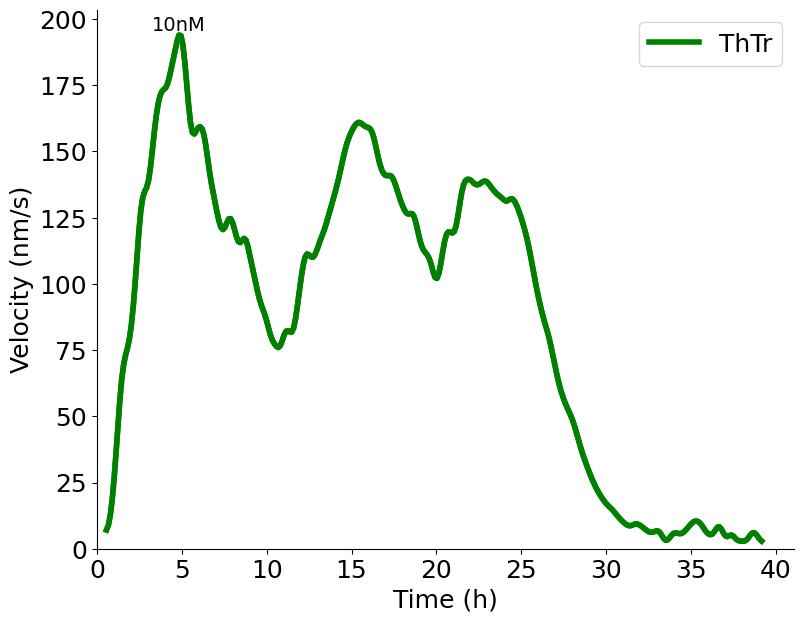

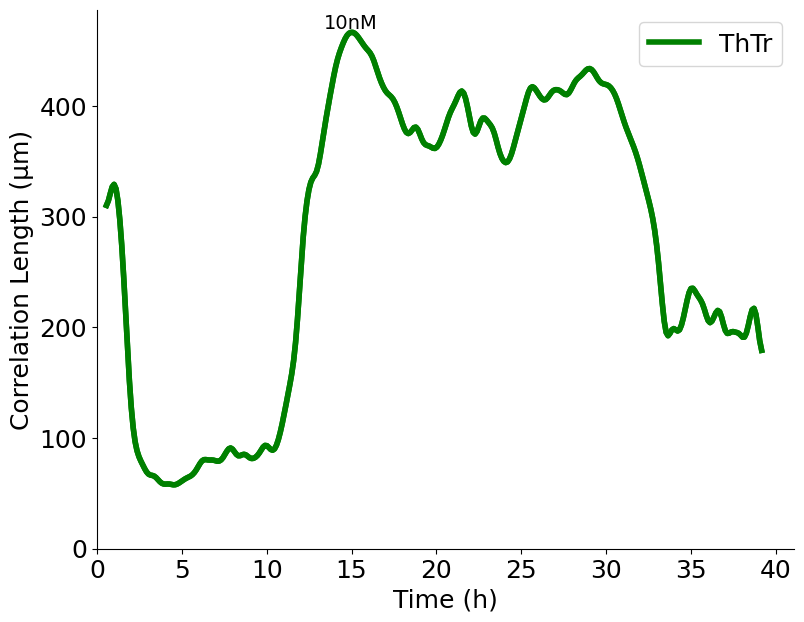

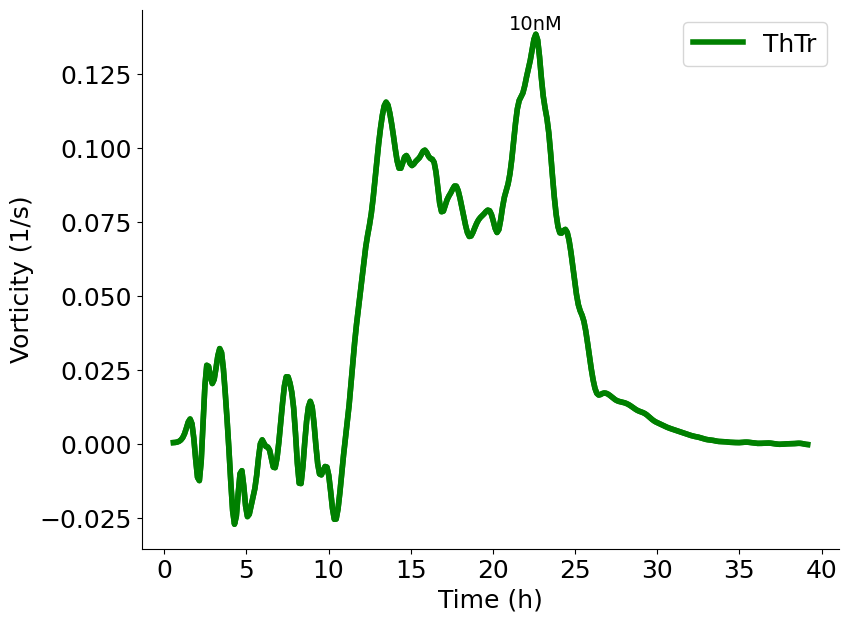

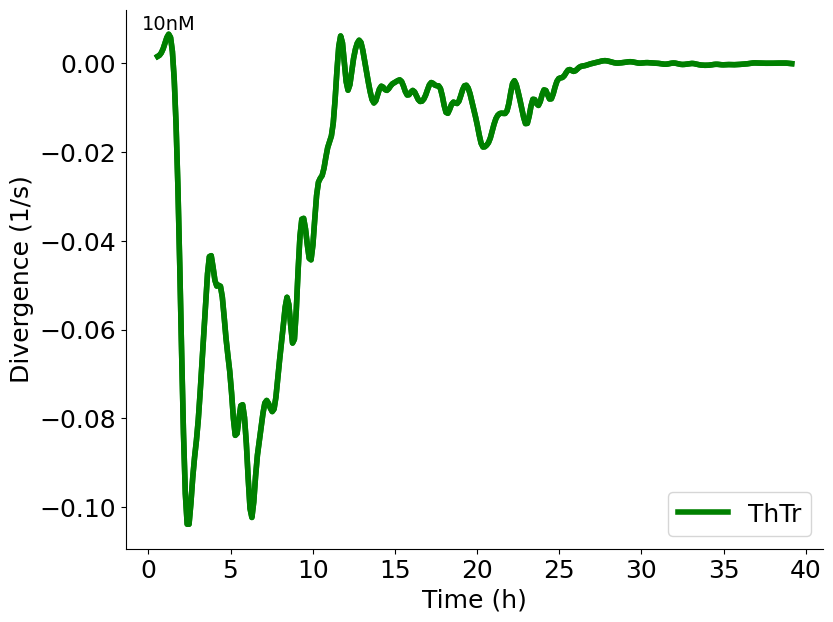

In [152]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import FuncFormatter, LogLocator
from sklearn.decomposition import PCA

# ------------------------------
# Plotting functions (using a list of proteins)
# ------------------------------

def plot_protein_concentration_vs_time(ax, df, proteins, dna_concentrations, time_col,
                                        color_map, velocity_threshold, time_unit, colored_DNAnM,
                                        display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    # Use full time range
    for protein in proteins:
        for i, dna_conc in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_conc)) & (df['protein'] == protein)] \
                          .dropna(subset=['Protein Concentration_nM', 'Time_h'])
            if df_filtered.empty:
                continue
            smoothed_conc = gaussian_filter1d(df_filtered['Protein Concentration_nM'], sigma=1)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(df_filtered['Time_h'], smoothed_conc,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw, linestyle='--')
            if display_dna_text:
                idx_max = smoothed_conc.argmax()
                t_max = df_filtered['Time_h'].iloc[idx_max]
                conc_max = smoothed_conc[idx_max]
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                ax.text(t_max, conc_max, f'{dna_conc}nM', fontsize=14,  ha='left', color=txt_color)
            if i == 0:
                ax.plot(df_filtered['Time_h'], smoothed_conc, label=protein,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw, linestyle='--')
    ax.set_xlabel('Time (h)', fontsize=18)
    ax.set_ylabel('Motor (nM)', fontsize=18)
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_mean_velocity_vs_time(ax, df, proteins, dna_concentrations, time_col,
                               color_map, velocity_threshold, time_unit, colored_DNAnM,
                               display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        for i, dna in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                          .dropna(subset=['velocity magnitude [m/s]_mean', time_col])
            if df_filtered.empty:
                continue
            smoothed_vel = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'] * 1e9, sigma=2)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(df_filtered[time_col], smoothed_vel,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
            if display_dna_text and not df_filtered.empty:
                idx = smoothed_vel.argmax()
                t_peak = df_filtered[time_col].iloc[idx]
                v_peak = smoothed_vel[idx]
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                ax.text(t_peak, v_peak, f'{dna}nM', fontsize=14, ha='center', va='bottom', color=txt_color)
            if i == 0:
                ax.plot(df_filtered[time_col], smoothed_vel, label=protein,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
    ax.set_xlabel(f'Time ({time_unit})', fontsize=18)
    ax.set_ylabel('Velocity (nm/s)', fontsize=18)
    ax.tick_params(labelsize=18)
    # ax.set_yscale('log')
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()
        plt.show()


def plot_mean_power_vs_time(ax, df, proteins, dna_concentrations, time_col,
                            color_map, velocity_threshold, time_unit, colored_DNAnM,
                            display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        for i, dna_conc in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_conc)) & (df['protein'] == protein)] \
                          .dropna(subset=['power [W]_mean', time_col])
            if df_filtered.empty:
                continue
            smoothed_power = gaussian_filter1d(df_filtered['power [W]_mean'], sigma=8)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(df_filtered[time_col], smoothed_power,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
            if display_dna_text and not df_filtered.empty:
                idx = smoothed_power.argmax()
                t_peak = df_filtered[time_col].iloc[idx]
                p_peak = smoothed_power[idx]
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                ax.text(t_peak, p_peak, f'{dna_conc}nM', fontsize=14, ha='center', va='bottom', color=txt_color)
            if i == 0:
                ax.plot(df_filtered[time_col], smoothed_power, label=protein,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
    ax.set_xlabel(f'Time ({time_unit})', fontsize=18)
    ax.set_ylabel('Power (W)', fontsize=18)
    ax.set_yscale('log')
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()

def plot_correlation_length_vs_max_power(ax, df, proteins, dna_concentrations, time_col,
                                         color_map, velocity_threshold, time_unit, colored_DNAnM,
                                         display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, compute the maximum power (W) from a smoothed 'power [W]_mean'
    and plot Correlation Length (µm) vs Maximum Power.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        max_powers = []
        corr_lengths = []
        dna_labels = []
        for dna in sorted(dna_concentrations, reverse=True):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                     .dropna(subset=['power [W]_mean', 'correlation length [m]_mean'])
            if df_sub.empty:
                continue
            smoothed_power = gaussian_filter1d(df_sub['power [W]_mean'], sigma=2)
            idx = smoothed_power.argmax()
            max_pwr = smoothed_power[idx]
            max_powers.append(max_pwr)
            corr_lengths.append(df_sub['correlation length [m]_mean'].iloc[idx] * 1e6)
            dna_labels.append(f'{dna}nM')
        if max_powers:
            alphas = np.linspace(1.0, 0.1, len(max_powers))
            sizes = np.linspace(200, 80, len(max_powers))
            for i, (pwr, corr, alpha, size, label) in enumerate(zip(max_powers, corr_lengths, alphas, sizes, dna_labels)):
                ax.scatter(pwr, corr, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(pwr, corr, label, fontsize=14, ha='right', color=txt_color)
            ax.plot(max_powers, corr_lengths, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('Max Power (W)', fontsize=18)
    ax.set_ylabel('Correlation Length (µm)', fontsize=18)
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()

        
def plot_mean_velocity_vs_protein_concentration(ax, df, proteins, dna_concentrations, time_col,
                                                  color_map, velocity_threshold, time_unit, colored_DNAnM,
                                                  display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        for i, dna_conc in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_conc)) & (df['protein'] == protein)]\
                          .dropna(subset=['velocity magnitude [m/s]_mean', 'Protein Concentration_nM'])
            if df_filtered.empty:
                continue
            smoothed_vel = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'] * 1e9, sigma=5)
            smoothed_protein_conc = gaussian_filter1d(df_filtered['Protein Concentration_nM'], sigma=5)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(smoothed_protein_conc, smoothed_vel,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
            if display_dna_text and not df_filtered.empty:
                idx = smoothed_vel.argmax()
                x_peak = smoothed_protein_conc[idx]
                y_peak = smoothed_vel[idx]
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                ax.text(x_peak, y_peak, f'{dna_conc}nM', fontsize=14, ha='center', va='bottom', color=txt_color)
            if i == 0:
                ax.plot(smoothed_protein_conc, smoothed_vel, label=protein,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
    ax.set_xlabel('Motor (nM)', fontsize=18)
    ax.set_ylabel('Velocity (nm/s)', fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_total_work_vs_dna_concentration(ax, df, proteins, dna_concentrations, time_col,
                                          color_map, velocity_threshold, time_unit, colored_DNAnM,
                                          display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        if protein in df['protein'].unique():
            pdata = df[df['protein'] == protein]
            dnas = []
            works = []
            for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
                sub = pdata[pdata['DNA nM'] == str(dna)]
                work_series = sub['work [J]_mean'].dropna()
                if not work_series.empty:
                    dnas.append(float(dna))
                    works.append(work_series.iloc[-1])
            if not works:
                continue
            alphas = np.linspace(1.0, 0.1, len(dnas))
            sizes = np.linspace(200, 80, len(dnas))
            for i, (x, y, alpha, size) in enumerate(zip(dnas, works, alphas, sizes)):
                ax.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(x, y, f'{x if x % 1 != 0 else int(x)}nM', fontsize=14, ha='right', color=txt_color)
            ax.plot(dnas, works, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('DNA (nM)', fontsize=18)
    ax.set_ylabel('Total Work (J)', fontsize=18)
    ax.set_yscale('log')
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    ax.set_xlim(left=1)  # Set x-axis limit to start at 1 (10**0)
    ax.set_xticks([10**i for i in range(0, 4)])  # Adjust xticks to start from 10**0
    if show_legends:
        ax.legend(loc='lower right', fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_translation_rate(ax, df, proteins, dna_concentrations, time_col,
                                                color_map, velocity_threshold, time_unit, colored_DNAnM,
                                                display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    # Use full time range (even if velocity data is missing)
    for protein in proteins:
        for i, dna_conc in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_conc)) & (df['protein'] == protein)] \
                          .dropna(subset=['Protein Concentration_nM', 'time (s)'])
            if df_filtered.empty:
                continue
            conc = df_filtered['Protein Concentration_nM'].values
            time_vals = df_filtered['Time_h'].values 
            smoothed_conc = gaussian_filter1d(conc, sigma=20)  # Apply Gaussian filter with sigma=5
            # Compute derivative in nM per hour then convert to nM/s by dividing by 3600.
            dC_dt = np.gradient(smoothed_conc, time_vals) / 3600
            # Apply Gaussian filter to the translation rate
            smoothed_dC_dt = gaussian_filter1d(dC_dt, sigma=20)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(time_vals, smoothed_dC_dt,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
            if display_dna_text:
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                peak_idx = smoothed_dC_dt.argmax()
                ax.text(time_vals[peak_idx], smoothed_dC_dt[peak_idx], f'{dna_conc}nM', fontsize=14, ha='left', color=txt_color)
            if i == 0:
                ax.plot(time_vals, smoothed_dC_dt,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw, label=protein)
    ax.set_xlabel('Time (h)', fontsize=18)
    ax.set_ylabel('Translation Rate (nM/s)', fontsize=18)
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_acceleration_vs_time(ax, df, proteins, dna_concentrations, time_col,
                                             color_map, velocity_threshold, time_unit, colored_DNAnM,
                                             display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each protein and DNA concentration, this function:
      - Filters the data for that (protein, DNA) combination.
      - Smooths the velocity data (using 'velocity magnitude [m/s]_mean' converted to nm/s).
      - Computes the time derivative of the smoothed velocity (np.gradient), dividing by 3600 to convert from per hour to per second (nm/s²).
      - Plots the rate of change (acceleration) versus time.
    
    The x-axis remains in hours while the y-axis is in nm/s².
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
        
    for protein in proteins:
        for i, dna in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)] \
                          .dropna(subset=['velocity magnitude [m/s]_mean', time_col])
            if df_filtered.empty:
                continue
            # Convert velocity to nm/s and smooth it
            smoothed_vel = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'] * 1e9, sigma=1)
            # Compute the rate of change (acceleration) in nm/s².
            # np.gradient returns derivative in (nm/s)/h, so divide by 3600.
            if time_unit == 'h':
                dVel_dt = np.gradient(smoothed_vel, df_filtered[time_col].values) / 3600.0
            else:   
                dVel_dt = np.gradient(smoothed_vel, df_filtered[time_col].values) / 60
            # Apply Gaussian filter with sigma=15 to the acceleration data
            smoothed_dVel_dt = gaussian_filter1d(dVel_dt, sigma=1)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(df_filtered[time_col], smoothed_dVel_dt,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
            if display_dna_text:
                # Label at the point of maximum absolute acceleration
                idx = np.argmax(np.abs(smoothed_dVel_dt))
                t_peak = df_filtered[time_col].iloc[idx]
                rate_peak = smoothed_dVel_dt[idx]
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                ax.text(t_peak, rate_peak, f'{dna}nM', fontsize=14, ha='left', color=txt_color)
            if i == 0:
                ax.plot(df_filtered[time_col], smoothed_dVel_dt,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw, label=protein)
    ax.set_xlabel(f'Time ({time_unit})', fontsize=18)
    ax.set_ylabel('Acceleration (nm/s²)', fontsize=18)
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()

def plot_max_velocity_vs_dna_concentration(ax, df, proteins, dna_concentrations, time_col,
                                             color_map, velocity_threshold, time_unit, colored_DNAnM,
                                             display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes the maximum velocity (nm/s)
    and plots it vs DNA concentration.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        velocities = []
        dnas = []
        for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            sub = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna))]\
                  .dropna(subset=['velocity magnitude [m/s]_mean'])
            if sub.empty:
                continue
            max_vel = np.max(sub['velocity magnitude [m/s]_mean']) * 1e9
            velocities.append(max_vel)
            dnas.append(float(dna))
        if velocities:
            alphas = np.linspace(1.0, 0.1, len(velocities))
            sizes = np.linspace(200, 80, len(velocities))
            for i, (v, d, alpha, size) in enumerate(zip(velocities, dnas, alphas, sizes)):
                ax.scatter(d, v, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(d, v, f'{d}nM', fontsize=14, ha='right', color=txt_color)
            ax.plot(dnas, velocities, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('DNA (nM)', fontsize=18)
    ax.set_ylabel('Max Velocity (nm/s)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    ax.set_xticks([10**i for i in range(-1, 4)])
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_max_power_vs_dna_concentration(ax, df, proteins, dna_concentrations, time_col,
                                        color_map, velocity_threshold, time_unit, colored_DNAnM,
                                        display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes the maximum power (W)
    and plots it vs DNA concentration.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        powers = []
        dnas = []
        for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            sub = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna))]\
                  .dropna(subset=['power [W]_mean'])
            if sub.empty:
                continue
            max_pwr = np.max(sub['power [W]_mean'])
            powers.append(max_pwr)
            dnas.append(float(dna))
        if powers:
            alphas = np.linspace(1.0, 0.1, len(powers))
            sizes = np.linspace(200, 80, len(powers))
            for i, (pwr, d, alpha, size) in enumerate(zip(powers, dnas, alphas, sizes)):
                ax.scatter(d, pwr, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(d, pwr, f'{d}nM', fontsize=14, ha='right', color=txt_color)
            ax.plot(dnas, powers, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('DNA (nM)', fontsize=18)
    ax.set_ylabel('Max Power (W)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks([10**i for i in range(-1, 4)])
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_max_production_rate_vs_dna_concentration(ax, df, proteins, dna_concentrations, time_col,
                                                  color_map, velocity_threshold, time_unit, colored_DNAnM,
                                                  display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes the maximum protein production rate
    (i.e. maximum of the derivative d[Protein]/dt in nM/s) and plots it vs DNA concentration.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        max_rates = []
        dnas = []
        for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                      .dropna(subset=['Protein Concentration_nM', 'Time_h'])
            if df_sub.empty:
                continue
            conc = df_sub['Protein Concentration_nM'].values
            time_vals = df_sub['Time_h'].values
            smoothed_conc = gaussian_filter1d(conc, sigma=1)
            dC_dt = np.gradient(smoothed_conc, time_vals) / 3600.0
            max_rate = np.max(dC_dt)
            max_rates.append(max_rate)
            dnas.append(float(dna))
        if max_rates:
            alphas = np.linspace(1.0, 0.1, len(max_rates))
            sizes = np.linspace(200, 80, len(max_rates))
            for i, (rate, d, alpha, size) in enumerate(zip(max_rates, dnas, alphas, sizes)):
                ax.scatter(d, rate, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(d, rate, f'{d}nM', fontsize=14, ha='right', color=txt_color)
            ax.plot(dnas, max_rates, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('DNA (nM)', fontsize=18)
    ax.set_ylabel('Max Translation Rate (nM/s)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    ax.set_xticks([10**i for i in range(-1, 4)])
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_activation_onset_vs_protein_concentration(ax, df, proteins, dna_concentrations, time_col,
                                                     color_map, velocity_threshold, time_unit, colored_DNAnM,
                                                     display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        activation_onsets = []
        protein_concs = []
        dna_labels = []
        for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            df_sub = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna))]\
                     .dropna(subset=['velocity magnitude [m/s]_mean', time_col])
            if df_sub.empty:
                continue
            smoothed_vel = gaussian_filter1d(df_sub['velocity magnitude [m/s]_mean'], sigma=1)
            df_sub = df_sub.copy()
            df_sub['smoothed_velocity'] = smoothed_vel
            peak_vel = df_sub['smoothed_velocity'].max()
            thresh = velocity_threshold * peak_vel
            above = df_sub[df_sub['smoothed_velocity'] >= thresh]
            if not above.empty:
                onset = above[time_col].iloc[0]
                conc = above['Protein Concentration_nM'].iloc[0]
                activation_onsets.append(onset)
                protein_concs.append(conc)
                dna_labels.append(f'{dna}nM')
        if activation_onsets:
            alphas = np.linspace(1.0, 0.1, len(activation_onsets))
            sizes = np.linspace(200, 80, len(activation_onsets))
            for i, (onset, conc, alpha, size, label) in enumerate(zip(activation_onsets, protein_concs, alphas, sizes, dna_labels)):
                ax.scatter(onset, conc, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(onset, conc, label, fontsize=14, ha='right', color=txt_color)
            ax.plot(activation_onsets, protein_concs, color=color_map.get(protein, 'black'),
                    alpha=0.5, label=protein)
    ax.set_xlabel('Activation Onset (min)' if time_unit == 'min' else 'Activation Onset (hours)', fontsize=18)
    ax.set_ylabel('Motor (nM)', fontsize=18)
    ax.tick_params(labelsize=18)

    if time_unit == 'h':
        ax.set_xlim(left=-1)
        max_time = df[time_col].max()
        ax.set_xlim(right=max_time)
    else:
        ax.set_xlim(left=0)
        
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_rate_at_max_power(ax, df, proteins, dna_concentrations, time_col,
                           color_map, velocity_threshold, time_unit, colored_DNAnM,
                           display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes:
      - The maximum power (W) from a smoothed version of 'power [W]_mean'
      - The protein production rate (nM/s) at the time when that power is maximal.
      
    The x-axis is the maximum power and the y-axis is the production rate at max power.
    Marker sizes and alpha are set with a gradient.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True

    for protein in proteins:
        max_powers = []
        prod_rates = []
        dnas = []
        for dna in sorted(dna_concentrations, reverse=True):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                      .dropna(subset=['Protein Concentration_nM', 'power [W]_mean', time_col])
            if df_sub.empty:
                continue
            time_vals = df_sub['Time_h'].values
            conc = df_sub['Protein Concentration_nM'].values
            smoothed_conc = gaussian_filter1d(conc, sigma=1)
            dC_dt = np.gradient(smoothed_conc, time_vals) / 3600.0  
            smoothed_power = gaussian_filter1d(df_sub['power [W]_mean'], sigma=2)
            idx_max = np.argmax(smoothed_power)
            max_pwr = smoothed_power[idx_max]
            prod_rate = dC_dt[idx_max]
            max_powers.append(max_pwr)
            prod_rates.append(prod_rate)
            dnas.append(float(dna))
        if max_powers:
            alphas = np.linspace(1.0, 0.1, len(max_powers))
            sizes = np.linspace(200, 80, len(max_powers))
            for i, (pwr, rate, alpha, size) in enumerate(zip(max_powers, prod_rates, alphas, sizes)):
                ax.scatter(pwr, rate, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(pwr, rate, f'{dnas[i]}nM', fontsize=14, ha='right', color=txt_color)
            ax.plot(max_powers, prod_rates, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('Max Power (W)', fontsize=18)
    ax.set_ylabel('Translation Rate at Max Power (nM/s)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_protein_concentration_vs_max_power(ax, df, proteins, dna_concentrations, time_col,
                                            color_map, velocity_threshold, time_unit, colored_DNAnM,
                                            display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes the maximum power (W)
    and plots Protein Concentration (nM) vs Max Power.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        max_powers = []
        prot_concs = []
        dna_labels = []
        for dna in sorted(dna_concentrations, reverse=True):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                     .dropna(subset=['power [W]_mean', 'Protein Concentration_nM'])
            if df_sub.empty:
                continue
            smoothed_power = gaussian_filter1d(df_sub['power [W]_mean'], sigma=2)
            idx = smoothed_power.argmax()
            max_pwr = smoothed_power[idx]
            max_powers.append(max_pwr)
            prot_concs.append(df_sub['Protein Concentration_nM'].iloc[idx])
            dna_labels.append(f'{dna}nM')
        if max_powers:
            alphas = np.linspace(1.0, 0.1, len(max_powers))
            sizes = np.linspace(200, 80, len(max_powers))
            for i, (pwr, conc, alpha, size, label) in enumerate(zip(max_powers, prot_concs, alphas, sizes, dna_labels)):
                ax.scatter(pwr, conc, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(pwr, conc, label, fontsize=14, ha='right', color=txt_color)
            ax.plot(max_powers, prot_concs, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('Max Power (W)', fontsize=18)
    ax.set_ylabel('Motor (nM)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_correlation_length_vs_max_power(ax, df, proteins, dna_concentrations, time_col,
                                         color_map, velocity_threshold, time_unit, colored_DNAnM,
                                         display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes the maximum power (W)
    and plots Correlation Length (µm) vs Max Power.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        max_powers = []
        corr_lengths = []
        dna_labels = []
        for dna in sorted(dna_concentrations, reverse=True):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                     .dropna(subset=['power [W]_mean', 'correlation length [m]_mean'])
            if df_sub.empty:
                continue
            smoothed_power = gaussian_filter1d(df_sub['power [W]_mean'], sigma=2)
            idx = smoothed_power.argmax()
            max_pwr = smoothed_power[idx]
            max_powers.append(max_pwr)
            corr_lengths.append(df_sub['correlation length [m]_mean'].iloc[idx] * 1e6)
            dna_labels.append(f'{dna}nM')
        if max_powers:
            alphas = np.linspace(1.0, 0.1, len(max_powers))
            sizes = np.linspace(200, 80, len(max_powers))
            for i, (pwr, corr, alpha, size, label) in enumerate(zip(max_powers, corr_lengths, alphas, sizes, dna_labels)):
                ax.scatter(pwr, corr, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(pwr, corr, label, fontsize=14, ha='right', color=txt_color)
            ax.plot(max_powers, corr_lengths, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('Max Power (W)', fontsize=18)
    ax.set_ylabel('Correlation Length (µm)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()

def plot_correlation_length_vs_time(ax, df, proteins, dna_concentrations, time_col,
                                    color_map, velocity_threshold, time_unit, colored_DNAnM,
                                    display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        for i, dna in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                          .dropna(subset=['correlation length [m]_mean', time_col])
            if df_filtered.empty:
                continue
            smoothed_corr = gaussian_filter1d(df_filtered['correlation length [m]_mean'], sigma=2)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(df_filtered[time_col], smoothed_corr * 1e6,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
            if display_dna_text and not df_filtered.empty:
                idx = smoothed_corr.argmax()
                t_peak = df_filtered[time_col].iloc[idx]
                corr_peak = smoothed_corr[idx] * 1e6
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                ax.text(t_peak, corr_peak, f'{dna}nM', fontsize=14, ha='center', va='bottom', color=txt_color)
            if i == 0:
                ax.plot(df_filtered[time_col], smoothed_corr * 1e6, label=protein,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
    ax.set_xlabel(f'Time ({time_unit})', fontsize=18)
    ax.set_ylabel('Correlation Length (µm)', fontsize=18)
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_motion_duration_vs_dna_concentration(ax, df, proteins, dna_concentrations, time_col,
                                               color_map, velocity_threshold, time_unit, colored_DNAnM,
                                               display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        xs = []
        durations = []
        for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            df_sub = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna))] \
                     .dropna(subset=['velocity magnitude [m/s]_mean', time_col])
            if df_sub.empty:
                continue
            smooth_vel = gaussian_filter1d(df_sub['velocity magnitude [m/s]_mean'], sigma=2)
            df_sub = df_sub.copy()
            df_sub['smooth_vel'] = smooth_vel
            peak_vel = df_sub['smooth_vel'].max()
            thresh = velocity_threshold * peak_vel
            above = df_sub[df_sub['smooth_vel'] >= thresh]
            if not above.empty:
                onset = above[time_col].iloc[0]
                dur = above[time_col].iloc[-1] - onset
                xs.append(float(dna))
                durations.append(dur)
        if durations:
            alphas = np.linspace(1.0, 0.1, len(durations))
            sizes = np.linspace(200, 80, len(durations))
            for i, (x, dur, alpha, size) in enumerate(zip(xs, durations, alphas, sizes)):
                ax.scatter(x, dur, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(x, dur, f'{x if x % 1 != 0 else int(x)}nM', fontsize=14, ha='right', color=txt_color)
            ax.plot(xs, durations, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('DNA (nM)', fontsize=18)
    ax.set_ylabel(f'Motion Duration ({time_unit})', fontsize=18)
    ax.set_xscale('log')
    ax.set_xticks([10**i for i in range(-1, 4)])
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_motion_duration_vs_activation_onset(ax, df, proteins, dna_concentrations, time_col,
                                             color_map, velocity_threshold, time_unit, colored_DNAnM,
                                             display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        onsets = []
        durations = []
        labels = []
        for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            df_sub = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna))] \
                     .dropna(subset=['velocity magnitude [m/s]_mean', time_col])
            if df_sub.empty:
                continue
            smooth_vel = gaussian_filter1d(df_sub['velocity magnitude [m/s]_mean'], sigma=2)
            df_sub = df_sub.copy()
            df_sub['smooth_vel'] = smooth_vel
            peak_vel = df_sub['smooth_vel'].max()
            thresh = velocity_threshold * peak_vel
            above = df_sub[df_sub['smooth_vel'] >= thresh]
            if not above.empty:
                onset = above[time_col].iloc[0]
                dur = above[time_col].iloc[-1] - onset
                onsets.append(onset)
                durations.append(dur)
                labels.append(f'{dna}nM')
        if onsets:
            alphas = np.linspace(1.0, 0.1, len(onsets))
            sizes = np.linspace(200, 80, len(onsets))
            for i, (o, d, alpha, size, label) in enumerate(zip(onsets, durations, alphas, sizes, labels)):
                ax.scatter(o, d, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(o, d, label, fontsize=14, ha='right', color=txt_color)
            ax.plot(onsets, durations, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('Activation Onset (min)' if time_unit == 'min' else 'Activation Onset (h)', fontsize=18)
    ax.set_ylabel(f'Motion Duration ({time_unit})', fontsize=18)
    ax.tick_params(labelsize=18)
    if time_unit == 'h':
        ax.set_xlim(left=-1)
        max_time = df[time_col].max()
        ax.set_xlim(right=max_time)
    else:
        ax.set_xlim(left=0)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_vorticity_vs_time(ax, df, proteins, dna_concentrations, time_col,
                           color_map, velocity_threshold, time_unit, colored_DNAnM,
                           display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        for i, dna in enumerate(sorted(dna_concentrations, reverse=True)):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)] \
                     .dropna(subset=['vorticity [1/s]_mean', time_col])
            if df_sub.empty:
                continue
            smooth_vort = gaussian_filter1d(df_sub['vorticity [1/s]_mean'], sigma=2)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(df_sub[time_col], smooth_vort,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
            if display_dna_text and not df_sub.empty:
                idx = smooth_vort.argmax()
                t_peak = df_sub[time_col].iloc[idx]
                v_peak = smooth_vort[idx]
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                ax.text(t_peak, v_peak, f'{dna}nM', fontsize=14, ha='center', va='bottom', color=txt_color)
            if i == 0:
                ax.plot(df_sub[time_col], smooth_vort, label=protein,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
    ax.set_xlabel(f'Time ({time_unit})', fontsize=18)
    ax.set_ylabel('Vorticity (1/s)', fontsize=18)
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_divergence_vs_time(ax, df, proteins, dna_concentrations, time_col,
                            color_map, velocity_threshold, time_unit, colored_DNAnM,
                            display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        for i, dna in enumerate(sorted(dna_concentrations, reverse=True)):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)] \
                     .dropna(subset=['divergence [1/s]_mean', time_col])
            if df_sub.empty:
                continue
            smooth_div = gaussian_filter1d(df_sub['divergence [1/s]_mean'], sigma=2)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(df_sub[time_col], smooth_div,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
            if display_dna_text and not df_sub.empty:
                idx = smooth_div.argmax()
                t_peak = df_sub[time_col].iloc[idx]
                v_peak = smooth_div[idx]
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                ax.text(t_peak, v_peak, f'{dna}nM', fontsize=14, ha='center', va='bottom', color=txt_color)
            if i == 0:
                ax.plot(df_sub[time_col], smooth_div, label=protein,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
    ax.set_xlabel(f'Time ({time_unit})', fontsize=18)
    ax.set_ylabel('Divergence (1/s)', fontsize=18)
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_vector_direction_vs_time(ax, df, proteins, dna_concentrations, time_col,
                                  color_map, velocity_threshold, time_unit, colored_DNAnM,
                                  display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        for i, dna in enumerate(sorted(dna_concentrations, reverse=True)):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)] \
                     .dropna(subset=['vector direction [degrees]_mean', time_col])
            if df_sub.empty:
                continue
            smooth_dir = gaussian_filter1d(df_sub['vector direction [degrees]_mean'], sigma=2)
            alpha = 1.0 - (i * 0.1)
            lw = 4.0 - (i * 0.5)
            ax.plot(df_sub[time_col], smooth_dir,
                    color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
            if display_dna_text and not df_sub.empty:
                txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                ax.text(df_sub[time_col].iloc[-1], smooth_dir[-1],
                        f'{dna}nM', fontsize=14, ha='left', color=txt_color)
            if i == 0:
                ax.plot(df_sub[time_col], smooth_dir, label=protein,
                        color=color_map.get(protein, 'black'), alpha=alpha, linewidth=lw)
    ax.set_xlabel(f'Time ({time_unit})', fontsize=18)
    ax.set_ylabel('Vector Direction (degrees)', fontsize=18)
    ax.tick_params(labelsize=18)
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()

# ------------------------------
# PCA Clustering 
# ------------------------------

def plot_PCA_clusters(ax, df, proteins, dna_concentrations, time_col,
                      color_map, velocity_threshold, time_unit, colored_DNAnM,
                      display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes:
      - Maximum velocity (nm/s)
      - Protein concentration at max velocity
      - Total work (last valid work [J]_mean)
      - Correlation length at max velocity (µm)
      - Activation onset (first time smoothed velocity exceeds threshold)
      - Motion duration (time difference between last and first time above threshold)
      - Vorticity at max velocity (vorticity [1/s]_mean)
      - Divergence at max velocity (divergence [1/s]_mean)
      - Max power (maximum power [W]_mean)
      - Translation rate at max power (nM/s)
      
    Performs PCA on these 10 features and plots the first two principal components.
    Within each protein, a gradient of alphas and marker sizes is applied.
    """
    new_fig = False
    feature_list = []
    labels = []      # DNA concentration label
    prot_labels = [] # protein label

    for protein in proteins:
        for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            sub = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna))]
            if sub.empty:
                continue
            sub = sub.dropna(subset=['velocity magnitude [m/s]_mean', 
                                      'Protein Concentration_nM', 
                                      'work [J]_mean', 
                                      'correlation length [m]_mean',
                                      'vorticity [1/s]_mean',
                                      'divergence [1/s]_mean',
                                      'power [W]_mean',
                                      time_col])
            if sub.empty:
                continue
            smooth_vel = gaussian_filter1d(sub['velocity magnitude [m/s]_mean'], sigma=2)
            idx_max = np.argmax(smooth_vel)
            max_vel = smooth_vel[idx_max] * 1e9  # nm/s
            prot_conc_at_max = sub['Protein Concentration_nM'].iloc[idx_max]
            total_work = sub['work [J]_mean'].dropna().iloc[-1]
            corr_length = sub['correlation length [m]_mean'].iloc[idx_max] * 1e6
            vorticity_at_max = sub['vorticity [1/s]_mean'].iloc[idx_max]
            divergence_at_max = sub['divergence [1/s]_mean'].iloc[idx_max]
            max_power = np.max(sub['power [W]_mean'].dropna())
            idx_max_power = np.argmax(sub['power [W]_mean'].dropna())
            translation_rate_at_max_power = np.gradient(
                gaussian_filter1d(sub['Protein Concentration_nM'].values, sigma=1),
                sub['Time_h'].values
            )[idx_max_power] / 3600.0  # nM/s
            thresh = velocity_threshold * smooth_vel[idx_max]
            above = sub[smooth_vel >= thresh]
            if above.empty:
                continue
            activation_onset = above['Time_h'].iloc[0]
            motion_duration = above['Time_h'].iloc[-1] - activation_onset
            features = [max_vel, prot_conc_at_max, motion_duration, translation_rate_at_max_power
                        ]# activation_onset, motion_duration,  max_power,  corr_length,]
            feature_list.append(features)
            labels.append(f'{protein} {dna}nM')
            prot_labels.append(protein)
    if not feature_list:
        print("No data available for PCA.")
        return
    X = np.array(feature_list)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    explained = pca.explained_variance_ratio_
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    unique_prots = sorted(list(set(prot_labels)))
    for prot in unique_prots:
        indices = [i for i, p in enumerate(prot_labels) if p == prot]
        group_len = len(indices)
        group_alphas = np.linspace(1.0, 0.1, group_len)
        group_sizes = np.linspace(200, 80, group_len)
        for j, idx in enumerate(indices):
            x, y = X_pca[idx]
            ax.scatter(x, y, color=color_map.get(prot, 'black'),
                       s=group_sizes[j], alpha=group_alphas[j])
            if display_dna_text:
                ax.text(x, y, labels[idx], fontsize=12, ha='right', color=color_map.get(prot, 'black'))
    ax.set_xlabel(f'PC1 ({explained[0]*100:.1f}%)', fontsize=18)
    ax.set_ylabel(f'PC2 ({explained[1]*100:.1f}%)', fontsize=18)
    ax.set_title('PCA Clustering', fontsize=20)
    ax.tick_params(labelsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if show_legends:
        for prot in unique_prots:
            ax.scatter([], [], color=color_map.get(prot, 'black'), label=prot)
        ax.legend(fontsize=16)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_max_production_rate_vs_dna_concentration(ax, df, proteins, dna_concentrations, time_col,
                                                  color_map, velocity_threshold, time_unit, colored_DNAnM,
                                                  display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes the maximum protein production rate (nM/s)
    and plots it vs DNA concentration.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        max_rates = []
        dnas = []
        for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                      .dropna(subset=['Protein Concentration_nM', 'Time_h'])
            if df_sub.empty:
                continue
            conc = df_sub['Protein Concentration_nM'].values
            time_vals = df_sub['Time_h'].values
            smoothed_conc = gaussian_filter1d(conc, sigma=1)
            dC_dt = np.gradient(smoothed_conc, time_vals) / 3600.0
            filtered_dC_dt = gaussian_filter1d(dC_dt, sigma=30)
            max_rate = np.max(filtered_dC_dt)
            max_rates.append(max_rate)
            dnas.append(float(dna))
        if max_rates:
            alphas = np.linspace(1.0, 0.1, len(max_rates))
            sizes = np.linspace(200, 80, len(max_rates))
            for i, (rate, d, alpha, size) in enumerate(zip(max_rates, dnas, alphas, sizes)):
                ax.scatter(d, rate, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(d, rate, f'{d}nM', fontsize=14, ha='right', color=txt_color)
            ax.plot(dnas, max_rates, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('DNA (nM)', fontsize=18)
    ax.set_ylabel('Max Translation Rate (nM/s)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    ax.set_xticks([10**i for i in range(-1, 4)])
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_rate_at_max_power(ax, df, proteins, dna_concentrations, time_col,
                           color_map, velocity_threshold, time_unit, colored_DNAnM,
                           display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes:
      - The maximum power (W) from a smoothed version of 'power [W]_mean'
      - The protein production rate (nM/s) at the time when that power is maximal.
      
    The x-axis is the maximum power and the y-axis is the production rate at max power.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True

    for protein in proteins:
        max_powers = []
        prod_rates = []
        dnas = []
        for dna in sorted(dna_concentrations, reverse=True):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                      .dropna(subset=['Protein Concentration_nM', 'power [W]_mean', time_col])
            if df_sub.empty:
                continue
            time_vals = df_sub['Time_h'].values
            conc = df_sub['Protein Concentration_nM'].values
            smoothed_conc = gaussian_filter1d(conc, sigma=1)
            dC_dt = np.gradient(smoothed_conc, time_vals) / 3600.0  
            smoothed_power = gaussian_filter1d(df_sub['power [W]_mean'], sigma=2)
            idx_max = np.argmax(smoothed_power)
            max_pwr = smoothed_power[idx_max]
            prod_rate = dC_dt[idx_max]
            max_powers.append(max_pwr)
            prod_rates.append(prod_rate)
            dnas.append(float(dna))
        if max_powers:
            alphas = np.linspace(1.0, 0.1, len(max_powers))
            sizes = np.linspace(200, 80, len(max_powers))
            for i, (pwr, rate, alpha, size) in enumerate(zip(max_powers, prod_rates, alphas, sizes)):
                ax.scatter(pwr, rate, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(pwr, rate, f'{dnas[i]}nM', fontsize=14, ha='right', color=txt_color)
            ax.plot(max_powers, prod_rates, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('Max Power (W)', fontsize=18)
    ax.set_ylabel('Translation Rate at Max Power (nM/s)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_max_power_vs_protein_concentration(ax, df, proteins, dna_concentrations, time_col,
                                            color_map, velocity_threshold, time_unit, colored_DNAnM,
                                            display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes the maximum power (W)
    and plots Max Power vs Protein Concentration (nM).
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        max_powers = []
        prot_concs = []
        dna_labels = []
        for dna in sorted(dna_concentrations, reverse=True):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                     .dropna(subset=['power [W]_mean', 'Protein Concentration_nM'])
            if df_sub.empty:
                continue
            smoothed_power = gaussian_filter1d(df_sub['power [W]_mean'], sigma=2)
            idx = smoothed_power.argmax()
            max_pwr = smoothed_power[idx]
            max_powers.append(max_pwr)
            prot_concs.append(df_sub['Protein Concentration_nM'].iloc[idx])
            dna_labels.append(f'{dna}nM')
        if max_powers:
            alphas = np.linspace(1.0, 0.1, len(max_powers))
            sizes = np.linspace(200, 80, len(max_powers))
            for i, (conc, pwr, alpha, size, label) in enumerate(zip(prot_concs, max_powers, alphas, sizes, dna_labels)):
                ax.scatter(conc, pwr, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(conc, pwr, label, fontsize=14, ha='right', color=txt_color)
            ax.plot(prot_concs, max_powers, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('Motor (nM)', fontsize=18)
    ax.set_ylabel('Max Power (W)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_yscale('log')
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()


def plot_correlation_length_vs_max_power(ax, df, proteins, dna_concentrations, time_col,
                                         color_map, velocity_threshold, time_unit, colored_DNAnM,
                                         display_dna_text, show_legends, output_dir, plot_filename, fig_size):
    """
    For each (protein, DNA) combination, computes the maximum power (W)
    and plots Correlation Length (µm) vs Max Power.
    """
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
        new_fig = True
    for protein in proteins:
        max_powers = []
        corr_lengths = []
        dna_labels = []
        for dna in sorted(dna_concentrations, reverse=True):
            df_sub = df[(df['DNA nM'] == str(dna)) & (df['protein'] == protein)]\
                     .dropna(subset=['power [W]_mean', 'correlation length [m]_mean'])
            if df_sub.empty:
                continue
            smoothed_power = gaussian_filter1d(df_sub['power [W]_mean'], sigma=2)
            idx = smoothed_power.argmax()
            max_pwr = smoothed_power[idx]
            max_powers.append(max_pwr)
            corr_lengths.append(df_sub['correlation length [m]_mean'].iloc[idx] * 1e6)
            dna_labels.append(f'{dna}nM')
        if max_powers:
            alphas = np.linspace(1.0, 0.1, len(max_powers))
            sizes = np.linspace(200, 80, len(max_powers))
            for i, (pwr, corr, alpha, size, label) in enumerate(zip(max_powers, corr_lengths, alphas, sizes, dna_labels)):
                ax.scatter(pwr, corr, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                if display_dna_text:
                    txt_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                    ax.text(pwr, corr, label, fontsize=14, ha='right', color=txt_color)
            ax.plot(max_powers, corr_lengths, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)
    ax.set_xlabel('Max Power (W)', fontsize=18)
    ax.set_ylabel('Correlation Length (µm)', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_xscale('log')
    if show_legends:
        ax.legend(fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if new_fig:
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, plot_filename), dpi=500)
        plt.show()




# ------------------------------
# Master function with custom axis limits per plot
# ------------------------------
def generate_plots_master(df, proteins, dna_concentrations, output_dir,
                          velocity_threshold=0.2, time_unit='h', colored_DNAnM=True,
                          combined_plots=False, display_dna_text=True, show_legends=True,
                          plots_to_include=None, grid_size=(3,5), fig_size=(6,6)):
    """
    Generates selected plots from the DataFrame.
    """
    color_map = {
        'A': '#1f77b4', 'B': '#7f7f7f', 'C': '#2ca02c', 'D': '#d62728',
        'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#ff7f0e',
        'ThTr': 'green', 'AcSu2': '#8c564b', 'DiPu': '#9467bd', 'HeAl': '#7f7f7f',
        'NaGr': 'purple', 'Kif5': 'pink',
    }
    time_col = 'Time_min' if time_unit == 'min' else 'Time_h'
    proteins_str = '_'.join(proteins)
    dna_str = '_'.join(map(str, dna_concentrations))
    protein_output_dir = os.path.join(output_dir, proteins_str)
    os.makedirs(protein_output_dir, exist_ok=True)
    
    plot_functions = {
        'Protein_Concentration_vs_Time': plot_protein_concentration_vs_time,
        'Translation_Rate_vs_Time': plot_translation_rate,
        'Max_Production_Rate_vs_DNA_Concentration': plot_max_production_rate_vs_dna_concentration,
        'Mean_Velocity_vs_Time': plot_mean_velocity_vs_time,
        'Acceleration_vs_Time': plot_acceleration_vs_time,
        'Max_Velocity_vs_DNA_Concentration': plot_max_velocity_vs_dna_concentration,
        'Mean_Power_vs_Time': plot_mean_power_vs_time,
        'Max_Power_vs_Protein_Concentration': plot_max_power_vs_protein_concentration, 
        'Total_Work_vs_DNA_Concentration': plot_total_work_vs_dna_concentration,
        'Correlation_Length_vs_Time': plot_correlation_length_vs_time,
        'Activation_Onset_vs_Protein_Concentration': plot_activation_onset_vs_protein_concentration,
        'Max_Power_vs_DNA_Concentration': plot_max_power_vs_dna_concentration,
        'Mean_Velocity_vs_Protein_Concentration': plot_mean_velocity_vs_protein_concentration,
        'Motion_Duration_vs_Activation_Onset': plot_motion_duration_vs_activation_onset,
        'Motion_Duration_vs_DNA_Concentration': plot_motion_duration_vs_dna_concentration,
        'Rate_at_Max_Power': plot_rate_at_max_power,
        'Vorticity_vs_Time': plot_vorticity_vs_time,
        'Divergence_vs_Time': plot_divergence_vs_time,
        'Vector_Direction_vs_Time': plot_vector_direction_vs_time,
        'Correlation_Length_vs_Max_Power': plot_correlation_length_vs_max_power,
        'PCA_Clusters': plot_PCA_clusters,
    }
    
    if plots_to_include is None:
        plots_to_include = { key: {} for key in plot_functions.keys() }
    
    if combined_plots:
        num_plots = len(plots_to_include)
        rows, cols = grid_size
        fig, axes = plt.subplots(rows, cols, figsize=(cols * fig_size[0], rows * fig_size[1]),
                                 gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
        axes = axes.flatten()
        current_ax_index = 0
        
        for key in plots_to_include:
            if key not in plot_functions or plot_functions[key] is None:
                continue
            ax = axes[current_ax_index]
            plot_filename = f'{key}_{proteins_str}_{dna_str}.svg'
            plot_functions[key](ax, df, proteins, dna_concentrations, time_col,
                                color_map, velocity_threshold, time_unit, colored_DNAnM, display_dna_text,
                                show_legends, protein_output_dir, plot_filename, fig_size)
            limits = plots_to_include[key]
            if key != 'PCA_Clusters':
                if 'xlim' in limits:
                    ax.set_xlim(limits['xlim'])
                if 'ylim' in limits:
                    ax.set_ylim(limits['ylim'])
            current_ax_index += 1
            
        combined_filename = os.path.join(protein_output_dir, f'Combined_Plots_{proteins_str}_{dna_str}.svg')
        fig.savefig(combined_filename, dpi=500)
        plt.show()
    
    else:
        # Create individual plots
        for key in plots_to_include:
            if key not in plot_functions or plot_functions[key] is None:
                continue
            fig, ax = plt.subplots(figsize=fig_size)
            plot_filename = f'{key}_{proteins_str}_{dna_str}.svg'
            plot_functions[key](ax, df, proteins, dna_concentrations, time_col,
                                color_map, velocity_threshold, time_unit, colored_DNAnM, display_dna_text,
                                show_legends, protein_output_dir, plot_filename, fig_size)
            limits = plots_to_include[key]
            if key != 'PCA_Clusters':
                if 'xlim' in limits:
                    ax.set_xlim(limits['xlim'])
                if 'ylim' in limits:
                    ax.set_ylim(limits['ylim'])
            plt.savefig(os.path.join(protein_output_dir, plot_filename), dpi=500)
            plt.show()

# ------------------------------
# Example usage
# ------------------------------

# Generate titrations
titrations = [160 / (2 ** i) for i in range(11)]
titrations = [int(t) if t.is_integer() else t for t in titrations][:8]
print("Titrations:", titrations)



plots_to_include = {
    # 'Protein_Concentration_vs_Time': {'xlim': (0, None), 'ylim': (0, None)},
    # 'Translation_Rate_vs_Time': {'xlim': (0, None), 'ylim': (0, None)},
    'Mean_Velocity_vs_Time': {'xlim': (0, None), 'ylim': (0, None)},

    # 'Max_Production_Rate_vs_DNA_Concentration': {'xlim': (0, None), 'ylim': (0, None)},

#     'Acceleration_vs_Time': {'xlim': (None, None), 'ylim': (None, None)},
#     # 'Max_Velocity_vs_DNA_Concentration': {'xlim': (None, None), 'ylim': (None, None)},

    # 'Mean_Power_vs_Time': {'xlim': (0, None), 'ylim': (None, None)},
    # 'Max_Power_vs_Protein_Concentration':{'xlim': (None, None), 'ylim': (None, None)},
    # 'Total_Work_vs_DNA_Concentration': {'xlim': (None, None), 'ylim': (None, None)},

    'Correlation_Length_vs_Time': {'xlim': (0, None), 'ylim': (0, None)},
#     # 'Activation_Onset_vs_Protein_Concentration': {'xlim': (None, None), 'ylim': (None, None)},
#     # 'Max_Power_vs_DNA_Concentration': {'xlim': (None, None), 'ylim': (None, None)},

    # 'Mean_Velocity_vs_Protein_Concentration': {'xlim': (None, None), 'ylim': (None, None)},
#     # 'Motion_Duration_vs_Activation_Onset': {'xlim': (None, None), 'ylim': (None, None)},
#     # 'Motion_Duration_vs_DNA_Concentration': {'xlim': (None, None), 'ylim': (None, None)},
# ############
#     # 'Rate_at_Max_Power': {'xlim': (None, None), 'ylim': (None, None)},
    'Vorticity_vs_Time': {'xlim': (None, None), 'ylim': (None, None)},
    'Divergence_vs_Time': {'xlim': (None, None), 'ylim': (None, None)},
    # 'Vector_Direction_vs_Time': {'xlim': (None, None), 'ylim': (None, None)},
    # 'Correlation_Length_vs_Max_Power': {'xlim': (None, None), 'ylim': (None, None)},  
    # 'PCA_Clusters': {'xlim': (None, 1000), 'ylim': (None, None)},  
}



# filters = [

#     ('AdPa', '160', 0, 40*60),
#     ('AdPa', '80', 0, 40*60),
#     ('AdPa', '40', 0, 42*60),
#     ('AdPa', '20', 0, 6000),
#     ('AdPa', '10', 0, 6000),
#     ('AdPa', '5', 0, 6000),
#     ('AdPa', '2.5', 0, 6000),
#     ('AdPa', '1.25', 0, 6000),
# ]




proteins = [
    # 'A', 
    # 'B',
    # 'C', 
    # 'D',
    # 'E',
    # # 'F',
    # 'G',
    # 'H', 
    'ThTr', 
    # 'HeAl',
    # 'AcSu2',
    # 'DiPu',
    # 'NaGr',
    # 'Blesto',
    # 'AdPa',
    # "Kif5",
]  

# Assume filter_and_replace_values is defined elsewhere and loads & preprocesses your DataFrame.
# df_copy = filter_and_replace_values(df, filters)

generate_plots_master(df_copy, proteins, dna_concentrations=[10],
                        output_dir='../../../Thomson Lab Dropbox/David Larios/activedrops/main/all/Selected_Proteins_Plots',
                        velocity_threshold=0.3, time_unit='h', colored_DNAnM=False,
                        combined_plots=False, display_dna_text=True, show_legends=True,
                        plots_to_include=plots_to_include, grid_size=(1,2), fig_size=(9,7))

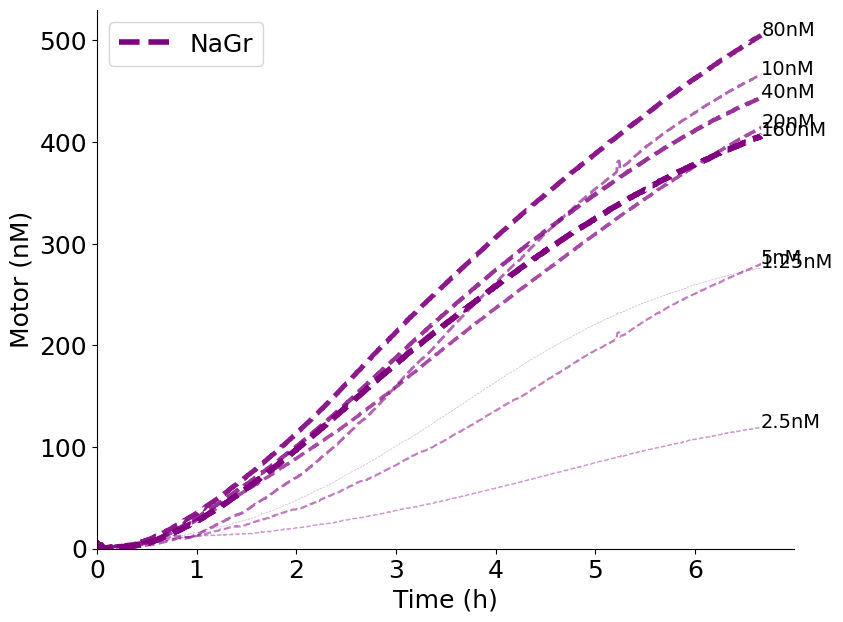

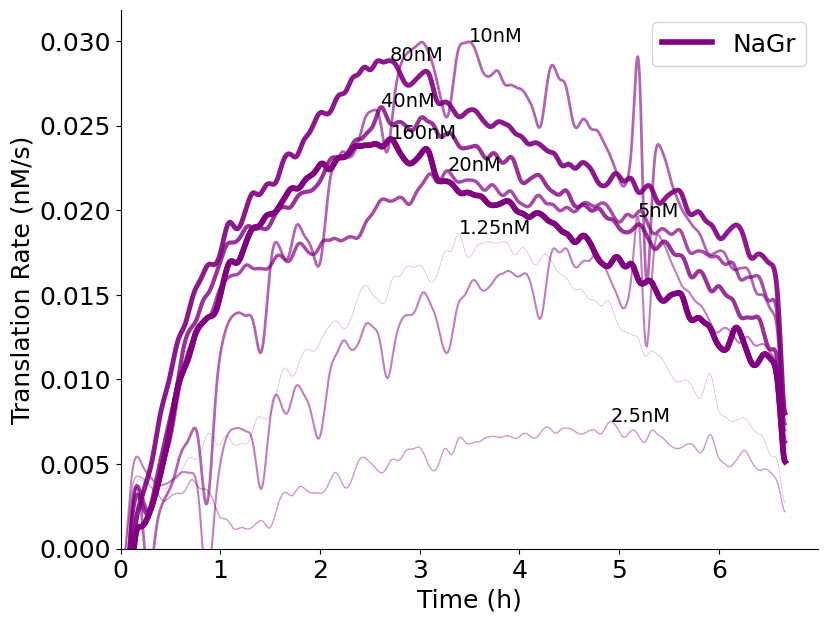

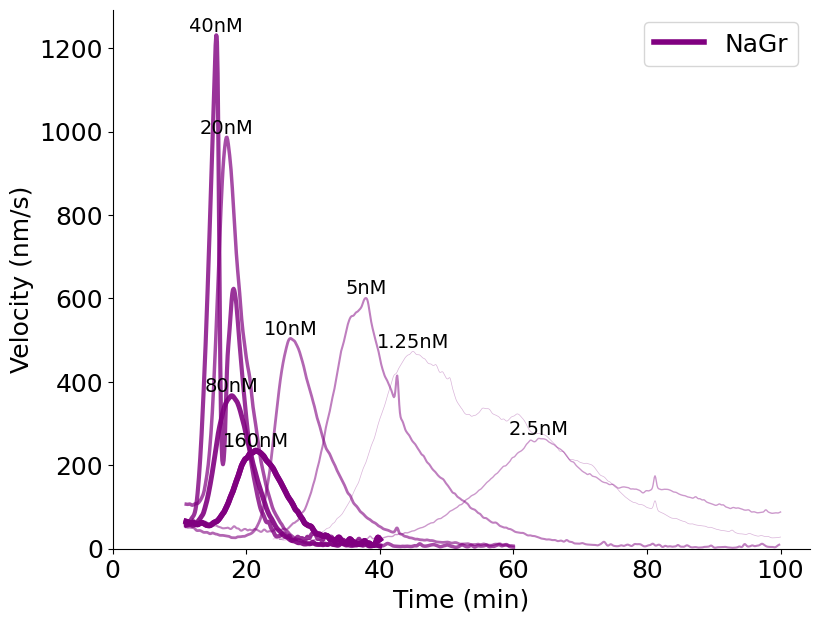

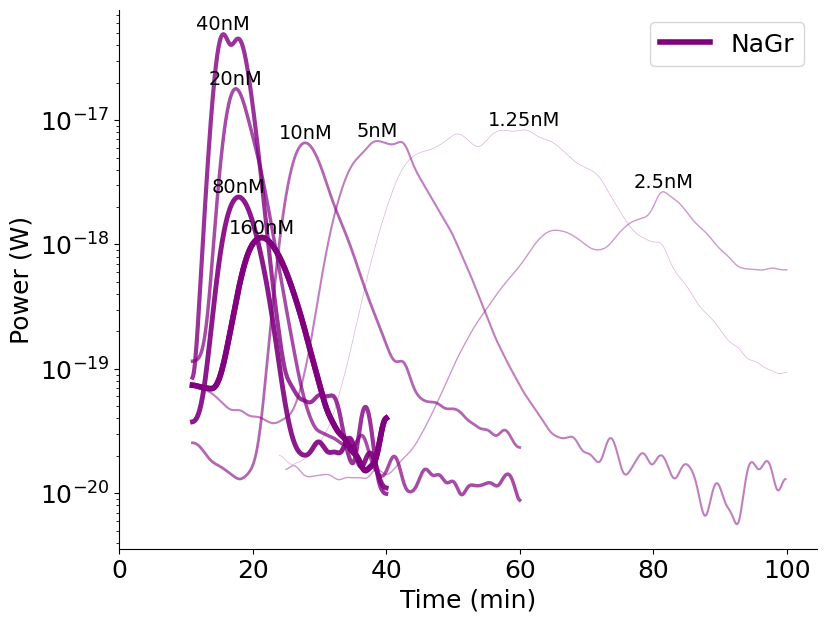

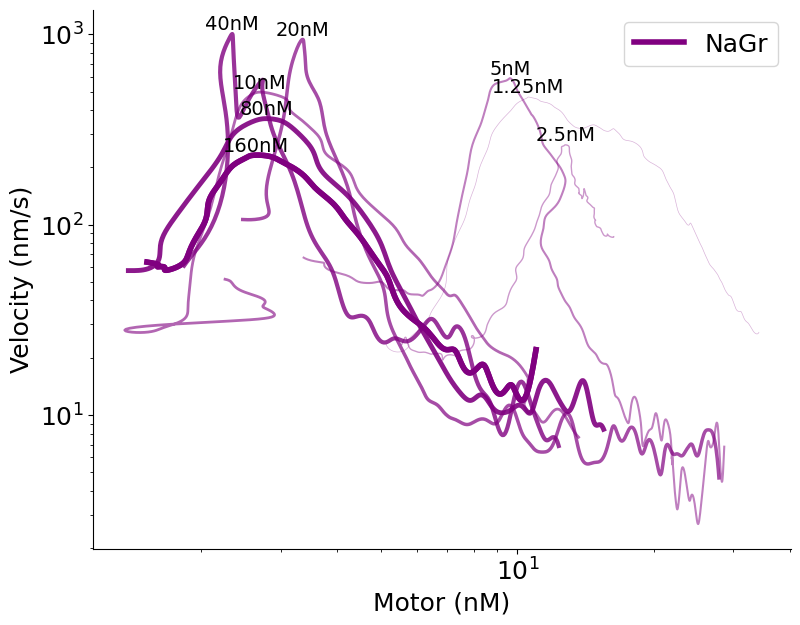

In [124]:

proteins = [
    # 'A', 
    # 'B',
    # 'C', 
    # 'D',
    # 'E',
    # 'F',
    # 'G',
    # 'H', 
    # 'ThTr', 
    # 'HeAl',
    # 'AcSu2',
    # 'DiPu',
    'NaGr',
    # 'Blesto',
    # 'AdPa',
    # "Kif5",
]  

# Assume filter_and_replace_values is defined elsewhere and loads & preprocesses your DataFrame.
# df_copy = filter_and_replace_values(df, filters)

generate_plots_master(df_copy, proteins, dna_concentrations=[160, 80, 40, 20, 10, 5, 2.5, 1.25],
                        output_dir='../../../Thomson Lab Dropbox/David Larios/activedrops/main/all/Selected_Proteins_Plots',
                        velocity_threshold=0.3, time_unit='min', colored_DNAnM=False,
                        combined_plots=False, display_dna_text=True, show_legends=True,
                        plots_to_include=plots_to_include, grid_size=(1,2), fig_size=(9,7))

In [9]:
df_copy.columns

Index(['condition', 'subcondition', 'time (s)', 'Time_min', 'Time_h',
       'Mean Intensity', 'Protein Concentration_ng_ul',
       'Protein Concentration_nM', 'Unnamed: 0', 'frame', 'x [m]_mean',
       'y [m]_mean', 'u [m/s]_mean', 'v [m/s]_mean', 'data type [-]_mean',
       'vorticity [1/s]_mean', 'velocity magnitude [m/s]_mean',
       'divergence [1/s]_mean', 'dcev [1]_mean', 'shear [1/s]_mean',
       'strain [1/s]_mean', 'vector direction [degrees]_mean',
       'correlation length [m]_mean', 'distance [m]_mean', 'power [W]_mean',
       'work [J]_mean', 'time (min)', 'time (h)', 'protein', 'DNA nM', 'kDa',
       'protein number', 'energy per protein', 'Number of Protein Molecules',
       'Rate of Change of Protein Molecules per Second',
       'Translation Rate aa_s'],
      dtype='object')

/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_2490/1826939984.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_160nM['total_work'] = filtered_df_160nM.groupby('protein')['power [W]_mean'].cumsum()


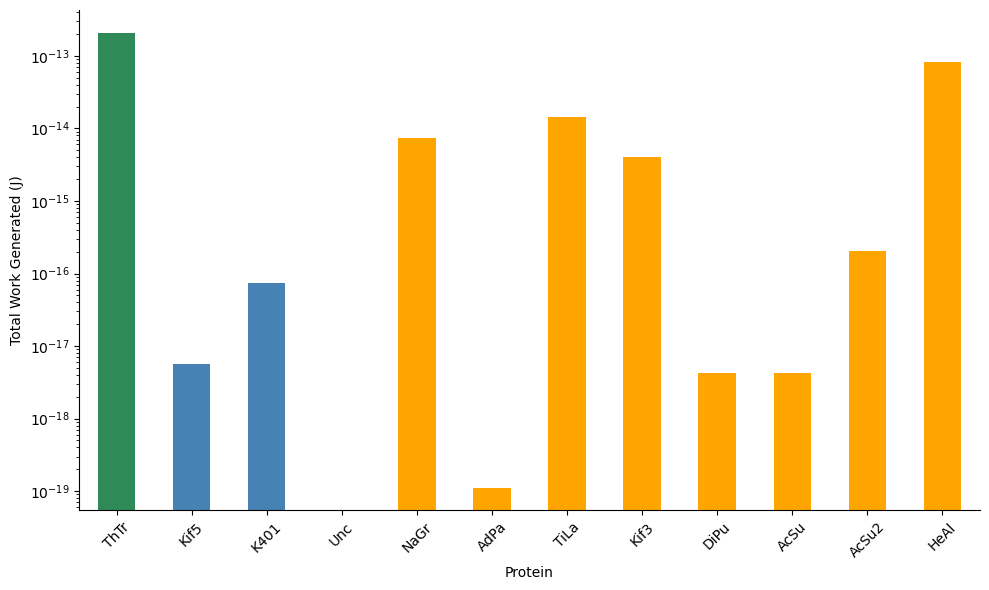

In [10]:
import matplotlib.pyplot as plt

# Exclude specific proteins
excluded_proteins = ['B', 'BleSto', 'E', 'F', 'C', 'D', 'G']
filtered_df = df_copy[~df_copy['protein'].isin(excluded_proteins)]

# Filter for DNA concentration of 160 nM
filtered_df_160nM = filtered_df

# Calculate the total work generated for each protein
filtered_df_160nM['total_work'] = filtered_df_160nM.groupby('protein')['power [W]_mean'].cumsum()

# Group by protein and get the last value of total work for each protein
total_work_per_protein_160nM = filtered_df_160nM.groupby('protein')['total_work'].last()

# Add separate bars for specific proteins at 80 nM DNA
# Assuming 'dna_concentration' is a column in df_copy, if not, replace with the correct column name
df_80nM = df_copy[df_copy['DNA nM'] == '5']
unc_work = df_80nM[df_80nM['protein'] == 'A']['power [W]_mean'].cumsum().iloc[-1]
acsu_work = df_80nM[df_80nM['protein'] == 'AcSu2']['power [W]_mean'].cumsum().iloc[-1]
tila_work = df_80nM[df_80nM['protein'] == 'HeAl']['power [W]_mean'].cumsum().iloc[-1]

# Rename proteins
total_work_per_protein_160nM = total_work_per_protein_160nM.rename(index={'A': 'K401', 'H': 'Kif3'})

# Add the separate bars to the total work series
total_work_per_protein_160nM['Unc'] = unc_work
total_work_per_protein_160nM['AcSu'] = acsu_work
total_work_per_protein_160nM['TiLa'] = tila_work

# Reorder the proteins
order = ['ThTr', 'Kif5', 'K401', 'Unc', 'NaGr', 'AdPa', 'TiLa', 'Kif3', 'DiPu', 'AcSu', 'AcSu2', 'HeAl']
total_work_per_protein_160nM = total_work_per_protein_160nM.reindex(order)

# Define colors for the bars
colors = {
    'ThTr': '#2E8B57',  # Steel Green
    'K401': '#4682B4',  # SteelBlue
    'Kif5': '#4682B4',  # SteelBlue
    'Unc': '#4682B4'    # SteelBlue
}
default_color = 'orange'
bar_colors = [colors.get(protein, default_color) for protein in total_work_per_protein_160nM.index]

# Plotting
plt.figure(figsize=(10, 6))
total_work_per_protein_160nM.plot(kind='bar', logy=True, color=bar_colors)  # Set y-axis to log scale
plt.xlabel('Protein')
plt.ylabel('Total Work Generated (J)')
# plt.title('Total Work Generated by Each Protein at 160 nM DNA (Excluding Specific Proteins)')
plt.xticks(rotation=45)
plt.tight_layout()

# Remove the top and right spines (box)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot as SVG
plt.savefig('../../../Downloads/total_work_per_protein.svg', format='svg')

plt.show()

In [11]:
df_copy['protein'].unique()

array(['A', nan, 'H', 'C', 'E', 'G', 'D', 'B', 'F', 'ThTr', 'AcSu2',
       'BleSto', 'DiPu', 'HeAl', 'NaGr', 'AdPa', 'Kif5'], dtype=object)

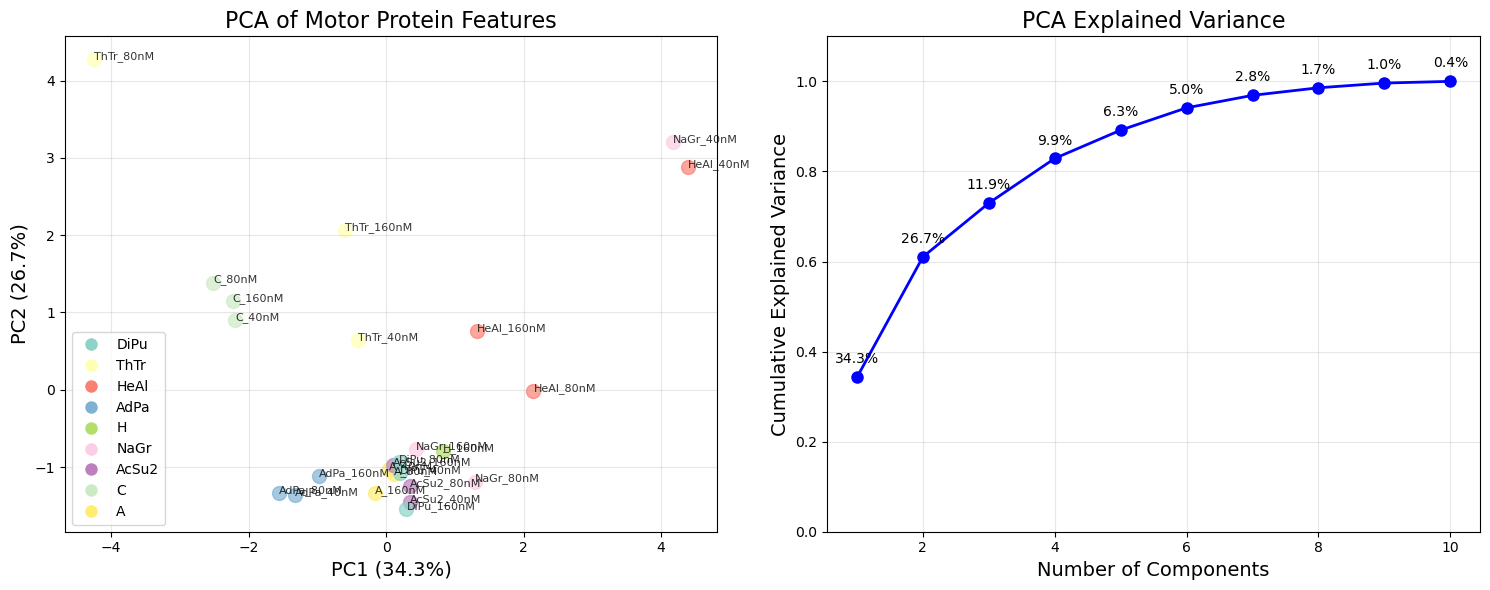


=== FEATURE IMPORTANCE (PC1 and PC2 loadings) ===
max_velocity_nm_s              | PC1:  0.387 | PC2:  0.388
protein_conc_at_max_vel_nM     | PC1: -0.386 | PC2:  0.353
motion_duration_h              | PC1: -0.404 | PC2:  0.068
activation_onset_h             | PC1: -0.269 | PC2: -0.003
max_power_W                    | PC1:  0.272 | PC2:  0.476
correlation_length_at_max_vel_um | PC1:  0.073 | PC2: -0.354
translation_rate_at_max_power_nM_s | PC1: -0.370 | PC2:  0.270
total_work_J                   | PC1: -0.160 | PC2:  0.509
vorticity_at_max_vel_1_s       | PC1:  0.349 | PC2:  0.156
divergence_at_max_vel_1_s      | PC1: -0.320 | PC2: -0.113

=== EXPLAINED VARIANCE ===
PC1: 34.3%
PC2: 26.7%
PC3: 11.9%
PC4: 9.9%
PC5: 6.3%
PC6: 5.0%
PC7: 2.8%
PC8: 1.7%
PC9: 1.0%
PC10: 0.4%

=== CUMULATIVE VARIANCE ===
PC1-1: 34.3%
PC1-2: 61.0%
PC1-3: 73.0%
PC1-4: 82.9%
PC1-5: 89.2%
PC1-6: 94.1%
PC1-7: 96.9%
PC1-8: 98.6%
PC1-9: 99.6%
PC1-10: 100.0%


(PCA(),
 array([[-1.68449834e-01, -1.33993757e+00,  4.52346305e-01,
          8.27128913e-01,  4.86362137e-01,  1.39273390e-01,
          1.05180518e+00,  7.24592473e-02, -1.80947355e-01,
          2.10000274e-01],
        [ 1.10986162e-01, -1.09432505e+00,  6.57920725e-01,
          3.66267202e-01,  5.27998016e-02,  5.39526035e-01,
          1.25336001e+00,  2.78699304e-01,  1.58454698e-01,
         -7.22535542e-02],
        [ 4.41364013e-02, -1.02504534e+00, -3.13891003e-01,
         -4.28615713e-02, -4.21208355e-02, -3.03794932e-01,
          9.35807804e-01,  1.25569919e-01,  3.49336766e-01,
         -1.96068615e-01],
        [ 8.30098171e-01, -7.88965120e-01, -7.15263924e-01,
          4.47578181e-01,  3.27556381e-01, -1.09755835e+00,
         -2.39280043e-02, -2.36779184e-01,  3.50857172e-01,
          4.40250059e-01],
        [-2.22937153e+00,  1.14509004e+00,  1.24566656e+00,
         -2.04387338e+00, -2.55262417e-01, -1.13544656e+00,
         -7.63535176e-01,  1.77445800e-01,  

In [12]:
def extract_pca_features(df, proteins, dna_concentrations, velocity_threshold=0.2):
    """
    Extract meaningful features from time series for PCA.
    """
    features_list = []
    sample_labels = []
    feature_names = [
        'max_velocity_nm_s',
        'protein_conc_at_max_vel_nM', 
        'motion_duration_h',
        'activation_onset_h',
        'max_power_W',
        'correlation_length_at_max_vel_um',
        'translation_rate_at_max_power_nM_s',
        'total_work_J',
        'vorticity_at_max_vel_1_s',
        'divergence_at_max_vel_1_s'
    ]
    
    for protein in proteins:
        for dna in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            # Filter data for this protein/DNA combination
            df_sub = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna))]\
                      .dropna(subset=['velocity magnitude [m/s]_mean', 'Time_h'])
            
            if df_sub.empty:
                continue
                
            # 1. Max velocity and protein concentration at max velocity
            smoothed_vel = gaussian_filter1d(df_sub['velocity magnitude [m/s]_mean'] * 1e9, sigma=2)
            idx_max_vel = np.argmax(smoothed_vel)
            max_velocity = smoothed_vel[idx_max_vel]
            protein_conc_at_max_vel = df_sub['Protein Concentration_nM'].iloc[idx_max_vel]
            
            # 2. Motion duration and activation onset
            thresh = velocity_threshold * max_velocity
            above_thresh = df_sub[smoothed_vel >= thresh]
            if above_thresh.empty:
                continue
            activation_onset = above_thresh['Time_h'].iloc[0]
            motion_duration = above_thresh['Time_h'].iloc[-1] - activation_onset
            
            # 3. Max power and translation rate at max power
            if 'power [W]_mean' in df_sub.columns:
                smoothed_power = gaussian_filter1d(df_sub['power [W]_mean'], sigma=2)
                idx_max_power = np.argmax(smoothed_power)
                max_power = smoothed_power[idx_max_power]
                
                # Translation rate at max power
                if 'Protein Concentration_nM' in df_sub.columns:
                    conc_smooth = gaussian_filter1d(df_sub['Protein Concentration_nM'], sigma=1)
                    translation_rate = np.gradient(conc_smooth, df_sub['Time_h'].values)[idx_max_power] / 3600.0
                else:
                    translation_rate = np.nan
            else:
                max_power = np.nan
                translation_rate = np.nan
            
            # 4. Correlation length at max velocity
            if 'correlation length [m]_mean' in df_sub.columns:
                corr_length = df_sub['correlation length [m]_mean'].iloc[idx_max_vel] * 1e6  # convert to um
            else:
                corr_length = np.nan
            
            # 5. Total work
            if 'work [J]_mean' in df_sub.columns:
                total_work = df_sub['work [J]_mean'].dropna().iloc[-1]
            else:
                total_work = np.nan
            
            # 6. Vorticity and divergence at max velocity
            if 'vorticity [1/s]_mean' in df_sub.columns:
                vorticity_at_max_vel = df_sub['vorticity [1/s]_mean'].iloc[idx_max_vel]
            else:
                vorticity_at_max_vel = np.nan
                
            if 'divergence [1/s]_mean' in df_sub.columns:
                divergence_at_max_vel = df_sub['divergence [1/s]_mean'].iloc[idx_max_vel]
            else:
                divergence_at_max_vel = np.nan
            
            # Collect features
            features = [
                max_velocity,
                protein_conc_at_max_vel,
                motion_duration,
                activation_onset,
                max_power,
                corr_length,
                translation_rate,
                total_work,
                vorticity_at_max_vel,
                divergence_at_max_vel
            ]
            
            # Only include if we have valid data
            if not any(np.isnan(features)):
                features_list.append(features)
                sample_labels.append(f'{protein}_{dna}nM')
    
    return np.array(features_list), sample_labels, feature_names

def perform_pca_analysis(df, proteins, dna_concentrations, velocity_threshold=0.2):
    """
    Perform comprehensive PCA analysis on motor protein data.
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    
    # Extract features
    X, sample_labels, feature_names = extract_pca_features(df, proteins, dna_concentrations, velocity_threshold)
    
    if X.shape[0] < 2:
        print("Not enough samples for PCA analysis")
        return
    
    # Standardize features (important for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Get explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Create color map for proteins
    unique_proteins = list(set([label.split('_')[0] for label in sample_labels]))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_proteins)))
    protein_colors = {protein: colors[i] for i, protein in enumerate(unique_proteins)}
    
    # Plot 1: PCA Scatter Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # PCA scatter plot
    for i, label in enumerate(sample_labels):
        protein = label.split('_')[0]
        color = protein_colors[protein]
        ax1.scatter(X_pca[i, 0], X_pca[i, 1], c=[color], s=100, alpha=0.7)
        ax1.annotate(label, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.8)
    
    ax1.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize=14)
    ax1.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize=14)
    ax1.set_title('PCA of Motor Protein Features', fontsize=16)
    ax1.grid(True, alpha=0.3)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=protein_colors[protein], markersize=10, label=protein)
                      for protein in unique_proteins]
    ax1.legend(handles=legend_elements, loc='best')
    
    # Plot 2: Explained Variance
    ax2.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Components', fontsize=14)
    ax2.set_ylabel('Cumulative Explained Variance', fontsize=14)
    ax2.set_title('PCA Explained Variance', fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.1)
    
    # Add percentage labels
    for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
        ax2.annotate(f'{var*100:.1f}%', (i+1, cum_var), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance
    print("\n=== FEATURE IMPORTANCE (PC1 and PC2 loadings) ===")
    for i, feature in enumerate(feature_names):
        pc1_loading = pca.components_[0, i]
        pc2_loading = pca.components_[1, i]
        print(f"{feature:30s} | PC1: {pc1_loading:6.3f} | PC2: {pc2_loading:6.3f}")
    
    print(f"\n=== EXPLAINED VARIANCE ===")
    for i, var in enumerate(explained_variance):
        print(f"PC{i+1}: {var*100:.1f}%")
    
    print(f"\n=== CUMULATIVE VARIANCE ===")
    for i, cum_var in enumerate(cumulative_variance):
        print(f"PC1-{i+1}: {cum_var*100:.1f}%")
    
    return pca, X_pca, sample_labels, feature_names

# Run the analysis
perform_pca_analysis(df_copy, 
                    proteins=['A', 'H', 'C', 'ThTr', 'HeAl', 'AcSu2', 'DiPu', 'NaGr', 'AdPa'], 
                    dna_concentrations=[160, 80, 40])


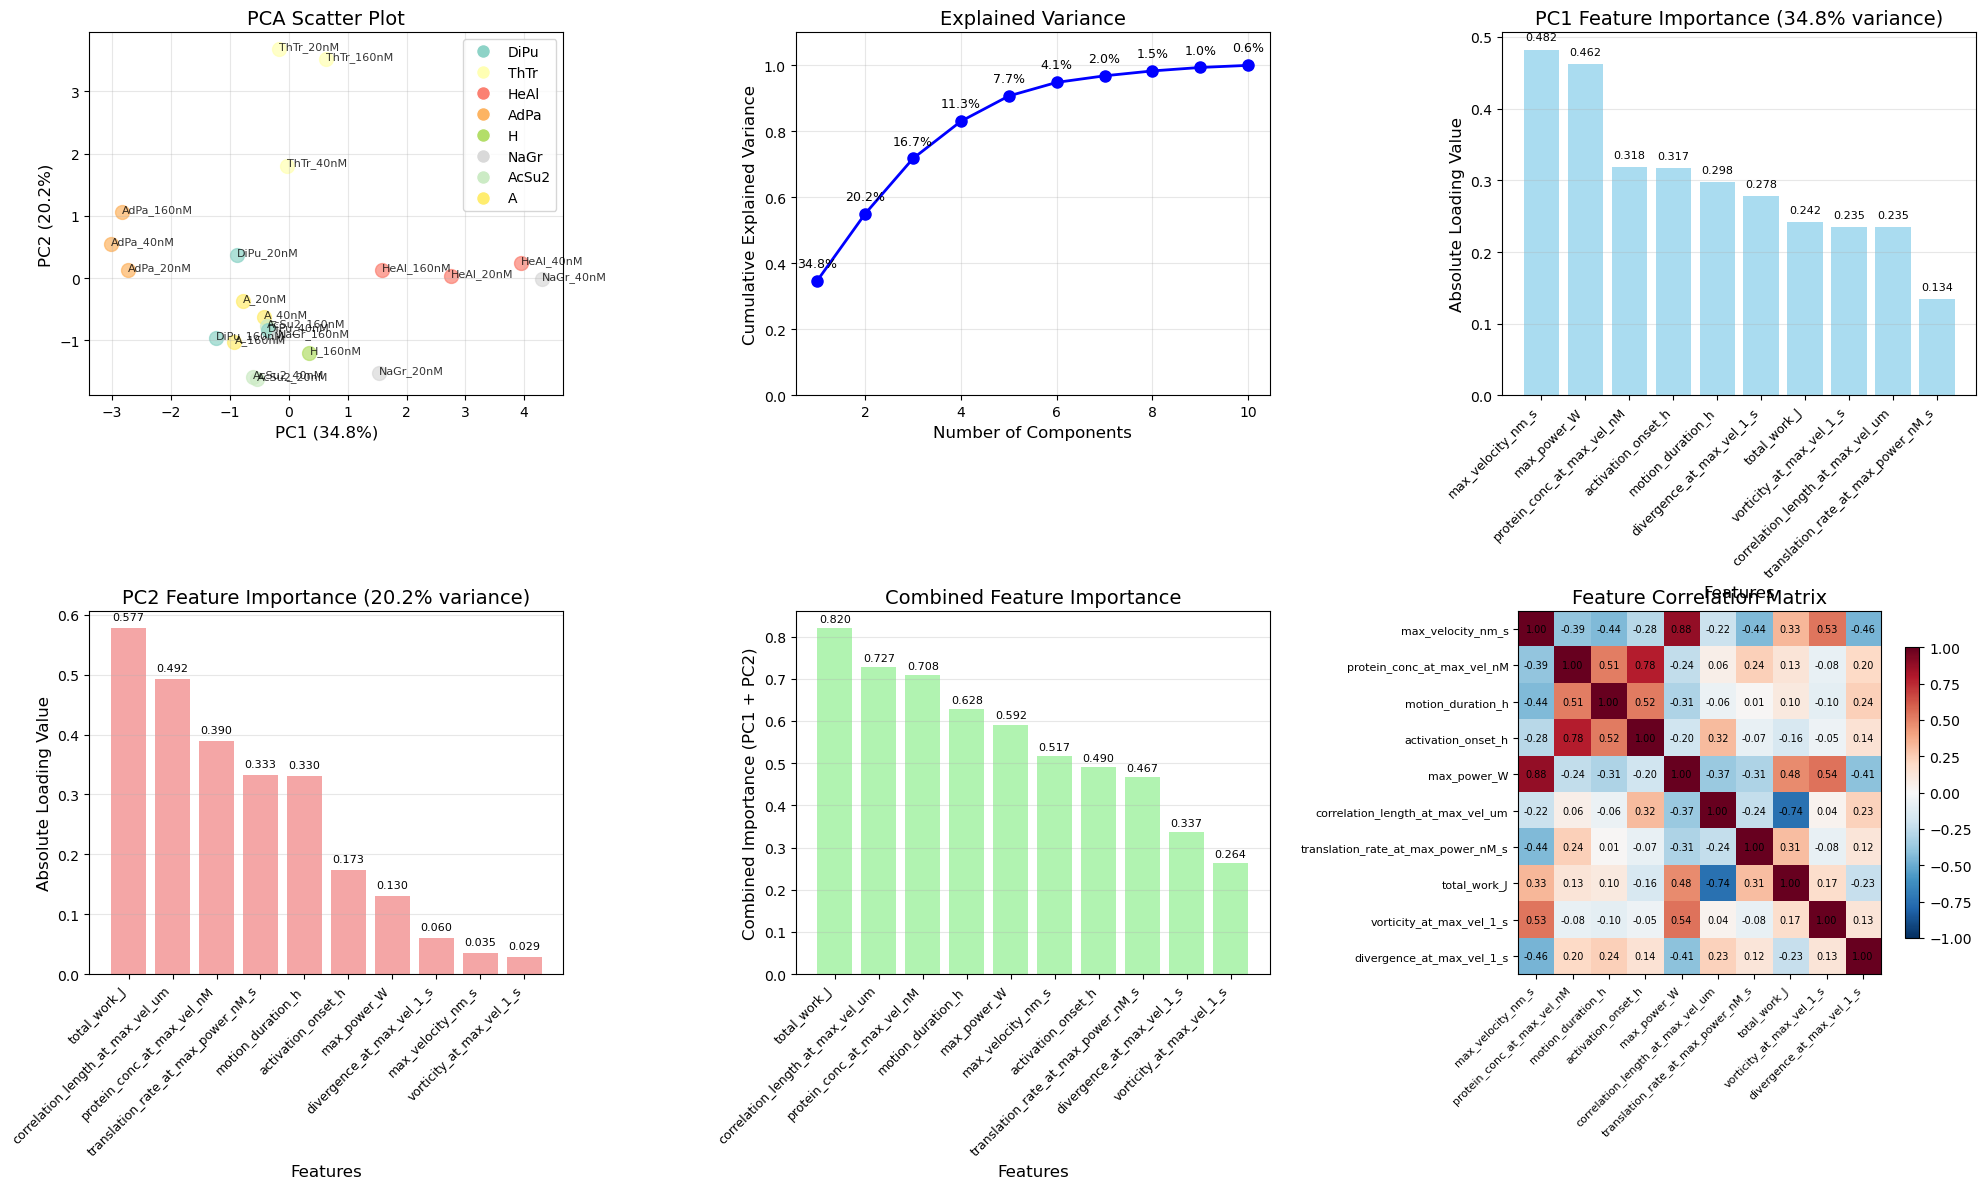


DETAILED FEATURE IMPORTANCE ANALYSIS

PC1 (34.8% variance) - Primary axis of variation:
  max_velocity_nm_s              | Loading:  0.482 | Importance:  0.482
  max_power_W                    | Loading:  0.462 | Importance:  0.462
  protein_conc_at_max_vel_nM     | Loading: -0.318 | Importance:  0.318
  activation_onset_h             | Loading: -0.317 | Importance:  0.317
  motion_duration_h              | Loading: -0.298 | Importance:  0.298
  divergence_at_max_vel_1_s      | Loading: -0.278 | Importance:  0.278
  total_work_J                   | Loading:  0.242 | Importance:  0.242
  vorticity_at_max_vel_1_s       | Loading:  0.235 | Importance:  0.235
  correlation_length_at_max_vel_um | Loading: -0.235 | Importance:  0.235
  translation_rate_at_max_power_nM_s | Loading: -0.134 | Importance:  0.134

PC2 (20.2% variance) - Secondary axis of variation:
  total_work_J                   | Loading:  0.577 | Importance:  0.577
  correlation_length_at_max_vel_um | Loading: -0.492 | Impor

(PCA(),
 array([[-0.923092  , -1.03364277,  0.05667217,  0.17387223,  1.3824352 ,
         -0.88275246, -0.53978992, -0.12762289,  0.30171869,  0.19453375],
        [-0.41727557, -0.62384757, -0.50788956,  0.07078808,  1.30152528,
         -0.24326456,  0.48508703,  0.26345716, -0.14811472, -0.22601473],
        [-0.77579851, -0.36387895, -0.34944374,  0.09042393,  1.68982699,
         -0.79864722,  0.36969233,  0.10123596,  0.08185268, -0.05069739],
        [ 0.35082289, -1.21303597, -0.45329949,  0.41839113,  0.75594056,
          0.96635002,  0.01744743,  0.10300087, -0.38889063,  0.03465526],
        [ 0.63481457,  3.51920613, -1.43669864, -0.73680353, -0.73783414,
          0.62709596, -0.72671527, -0.2107269 , -0.15833693, -0.14444327],
        [-0.02623485,  1.80842728, -0.93161271, -0.2210818 ,  0.42878597,
          0.27306159,  0.50482545,  0.19134696, -0.23814733,  0.02571485],
        [-0.17011671,  3.68374723, -0.27479429, -0.22819106,  1.26302365,
         -0.64373428, -0

In [13]:
# Comprehensive PCA Feature Importance Analysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d

def plot_pca_feature_importance(df, proteins, dna_concentrations, velocity_threshold=0.2):
    """
    Create comprehensive PCA analysis with feature importance visualization.
    """
    # Extract features using the existing function
    X, sample_labels, feature_names = extract_pca_features(df, proteins, dna_concentrations, velocity_threshold)
    
    if X.shape[0] < 2:
        print("Not enough samples for PCA analysis")
        return
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Get explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Create comprehensive plot
    fig = plt.figure(figsize=(20, 12))
    
    # 1. PCA Scatter Plot
    ax1 = plt.subplot(2, 3, 1)
    unique_proteins = list(set([label.split('_')[0] for label in sample_labels]))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_proteins)))
    protein_colors = {protein: colors[i] for i, protein in enumerate(unique_proteins)}
    
    for i, label in enumerate(sample_labels):
        protein = label.split('_')[0]
        color = protein_colors[protein]
        ax1.scatter(X_pca[i, 0], X_pca[i, 1], c=[color], s=100, alpha=0.7)
        ax1.annotate(label, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.8)
    
    ax1.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize=12)
    ax1.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize=12)
    ax1.set_title('PCA Scatter Plot', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=protein_colors[protein], markersize=10, label=protein)
                      for protein in unique_proteins]
    ax1.legend(handles=legend_elements, loc='best', fontsize=10)
    
    # 2. Explained Variance
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Components', fontsize=12)
    ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
    ax2.set_title('Explained Variance', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.1)
    
    for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
        ax2.annotate(f'{var*100:.1f}%', (i+1, cum_var), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
    
    # 3. Feature Importance for PC1
    ax3 = plt.subplot(2, 3, 3)
    pc1_loadings = pca.components_[0, :]
    feature_importance_pc1 = np.abs(pc1_loadings)
    sorted_idx_pc1 = np.argsort(feature_importance_pc1)[::-1]
    
    bars1 = ax3.bar(range(len(feature_names)), feature_importance_pc1[sorted_idx_pc1], 
                     color='skyblue', alpha=0.7)
    ax3.set_xlabel('Features', fontsize=12)
    ax3.set_ylabel('Absolute Loading Value', fontsize=12)
    ax3.set_title(f'PC1 Feature Importance ({explained_variance[0]*100:.1f}% variance)', fontsize=14)
    ax3.set_xticks(range(len(feature_names)))
    ax3.set_xticklabels([feature_names[i] for i in sorted_idx_pc1], rotation=45, ha='right', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 4. Feature Importance for PC2
    ax4 = plt.subplot(2, 3, 4)
    pc2_loadings = pca.components_[1, :]
    feature_importance_pc2 = np.abs(pc2_loadings)
    sorted_idx_pc2 = np.argsort(feature_importance_pc2)[::-1]
    
    bars2 = ax4.bar(range(len(feature_names)), feature_importance_pc2[sorted_idx_pc2], 
                     color='lightcoral', alpha=0.7)
    ax4.set_xlabel('Features', fontsize=12)
    ax4.set_ylabel('Absolute Loading Value', fontsize=12)
    ax4.set_title(f'PC2 Feature Importance ({explained_variance[1]*100:.1f}% variance)', fontsize=14)
    ax4.set_xticks(range(len(feature_names)))
    ax4.set_xticklabels([feature_names[i] for i in sorted_idx_pc2], rotation=45, ha='right', fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 5. Combined Feature Importance (PC1 + PC2)
    ax5 = plt.subplot(2, 3, 5)
    combined_importance = feature_importance_pc1 + feature_importance_pc2
    sorted_idx_combined = np.argsort(combined_importance)[::-1]
    
    bars3 = ax5.bar(range(len(feature_names)), combined_importance[sorted_idx_combined], 
                     color='lightgreen', alpha=0.7)
    ax5.set_xlabel('Features', fontsize=12)
    ax5.set_ylabel('Combined Importance (PC1 + PC2)', fontsize=12)
    ax5.set_title('Combined Feature Importance', fontsize=14)
    ax5.set_xticks(range(len(feature_names)))
    ax5.set_xticklabels([feature_names[i] for i in sorted_idx_combined], rotation=45, ha='right', fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 6. Feature Correlation Heatmap
    ax6 = plt.subplot(2, 3, 6)
    feature_corr = np.corrcoef(X_scaled.T)
    im = ax6.imshow(feature_corr, cmap='RdBu_r', vmin=-1, vmax=1)
    ax6.set_xticks(range(len(feature_names)))
    ax6.set_yticks(range(len(feature_names)))
    ax6.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=8)
    ax6.set_yticklabels(feature_names, fontsize=8)
    ax6.set_title('Feature Correlation Matrix', fontsize=14)
    
    # Add correlation values
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            text = ax6.text(j, i, f'{feature_corr[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=7)
    
    plt.colorbar(im, ax=ax6, shrink=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed feature importance
    print("\n" + "="*80)
    print("DETAILED FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    print(f"\nPC1 ({explained_variance[0]*100:.1f}% variance) - Primary axis of variation:")
    for i in sorted_idx_pc1:
        print(f"  {feature_names[i]:30s} | Loading: {pc1_loadings[i]:6.3f} | Importance: {feature_importance_pc1[i]:6.3f}")
    
    print(f"\nPC2 ({explained_variance[1]*100:.1f}% variance) - Secondary axis of variation:")
    for i in sorted_idx_pc2:
        print(f"  {feature_names[i]:30s} | Loading: {pc2_loadings[i]:6.3f} | Importance: {feature_importance_pc2[i]:6.3f}")
    
    print(f"\nCombined Importance (PC1 + PC2):")
    for i in sorted_idx_combined:
        print(f"  {feature_names[i]:30s} | Combined: {combined_importance[i]:6.3f}")
    
    print(f"\nExplained Variance Summary:")
    for i, var in enumerate(explained_variance):
        print(f"  PC{i+1}: {var*100:.1f}%")
    
    print(f"\nCumulative Variance:")
    for i, cum_var in enumerate(cumulative_variance):
        print(f"  PC1-{i+1}: {cum_var*100:.1f}%")
    
    return pca, X_pca, sample_labels, feature_names

# Run the comprehensive PCA analysis
plot_pca_feature_importance(df_copy, 
                           proteins=['A', 'H', 'ThTr', 'HeAl', 'AcSu2', 'DiPu', 'NaGr', 'AdPa'], 
                           dna_concentrations=[160, 20, 40, ])